In [3]:
import pandas as pd
df = pd.read_csv(r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv")
threshold = 12781.32299112502
df["anomaly_flags"] = (df["rmse"] > threshold).astype(int)

In [7]:
import pandas as pd
import numpy as np

# Load training RMSE data (e.g., rmse_Dec2019_00000...)
df_train = pd.read_csv(r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00000_20191206100500.pcap_20250616_054608.csv")

# Load test RMSE data (e.g., rmse_Dec2019_00002...)
df_test = pd.read_csv(r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv")

# Get the maximum RMSE from training data
max_train_rmse = df_train["rmse"].max()
print("Max RMSE from training:", max_train_rmse)

# Create anomaly flags in test data based on comparison
df_test["anomaly_flags"] = (df_test["rmse"] > max_train_rmse).astype(int)

np.percentile(df_train["rmse"], 99.0)

total_anomalies = df_test["anomaly_flags"].sum()
print(f"\n Total anomalies detected: {total_anomalies}")

# Optionally: display or save the results
print(df_test.head())
df_test.to_csv("flagged_output.csv", index=False)
print("\n✅ Results saved to 'flagged_rmse_output.csv'")

Max RMSE from training: 14304427.193060782

 Total anomalies detected: 2
   packet_idx     timestamp  rmse  anomaly_flags
0           1  1.575599e+09   0.0              0
1           2  1.575599e+09   0.0              0
2           3  1.575599e+09   0.0              0
3           4  1.575599e+09   0.0              0
4           5  1.575599e+09   0.0              0

✅ Results saved to 'flagged_rmse_output.csv'


Libraries imported successfully!

Configuration loaded. Please ensure file paths and column names are correct.
Training RMSE File: C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00000_20191206100500.pcap_20250616_054608.csv
Test RMSE File: C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv
Ground Truth File: C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\df_attacks_with_network_attacks.csv

Training RMSE data loaded successfully. Shape: (22024317, 3)
Training RMSE Head:
   packet_idx     timestamp  rmse
0           1  1.575598e+09   0.0
1           2  1.575598e+09   0.0
2           3  1.575598e+09   0.0
3           4  1.575598e+09   0.0
4           5  1.575598e+09   0.0

Test RMSE data loaded successfully. Shape: (22343612, 3)
Test RMSE Head:
   packet_idx     timestamp  rmse
0           1  1.575599e+09   0.0
1           2  1.575599e+09   0.0
2           3  1.575599

C:\Users\jckso\AppData\Local\Temp\ipykernel_33616\424582385.py:225: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\jckso\anaconda3\envs\kitsune_v3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


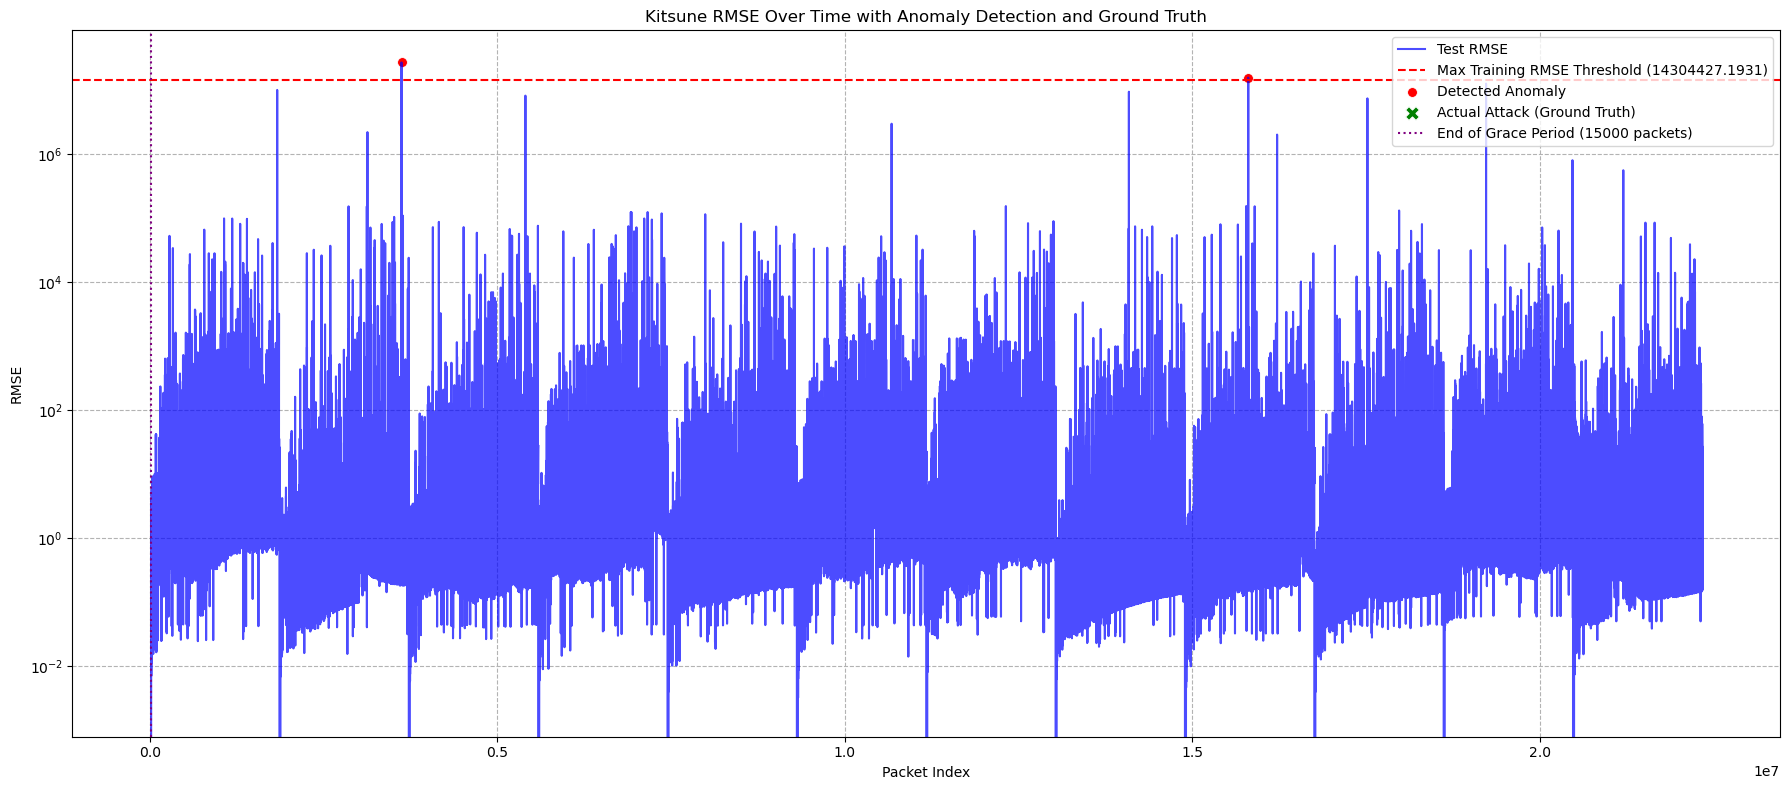


Analysis complete. Review the metrics and the plot to understand performance.
If the recall is low, consider adjusting the threshold calculation in example.py (e.g., using statistical threshold instead of max RMSE, or a different multiplier for std dev).


In [4]:
# Kitsune Anomaly Detection Evaluation Notebook

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("Libraries imported successfully!")

# --- Configuration Section ---
# IMPORTANT: Update these paths and filenames to match your setup

# Path to the directory where your Kitsune results are saved (e.g., "Results")
# Use a raw string (r"...") for Windows paths to avoid unicode escape errors.
# This should be the ABSOLUTE path to your 'Results' folder.
RESULTS_DIR = r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results" # <--- CORRECTED PATH HERE

# Filename for the training RMSE data (e.g., from a '00000' run, or a dedicated benign training run)
# This file should contain 'packet_idx', 'timestamp', 'rmse' columns.
TRAINING_RMSE_FILENAME = os.path.join(RESULTS_DIR, "rmse", "rmse_Dec2019_00000_20191206100500.pcap_20250616_054608.csv")
# ^^^ This part is now correctly relative to RESULTS_DIR/rmse

# Filename for the test RMSE data (the one you just ran and found 74 anomalies)
# This file should contain 'packet_idx', 'timestamp', 'rmse' columns.
TEST_RMSE_FILENAME = os.path.join(RESULTS_DIR, "rmse", "rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv")
# ^^^ REPLACE 'YYYYMMDD_HHMMSS' with the actual timestamp from your test RMSE file!
# Example: "rmse_Dec2019_00002_20250630_133000.csv"

# Path to your ground truth CSV file (the one with attack start/stop ranges)
# Ensure this file is in the same directory as your notebook or provide its full path.
GROUND_TRUTH_FILE = r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\df_attacks_with_network_attacks.csv"

# Kitsune grace periods (used to determine which packets are considered 'benign' for threshold calculation)
# These should match the FMgrace and ADgrace you used in example.py
FM_GRACE = 5000
AD_GRACE = 10000
TOTAL_GRACE_PERIOD = FM_GRACE + AD_GRACE

print("\nConfiguration loaded. Please ensure file paths and column names are correct.")
print(f"Training RMSE File: {TRAINING_RMSE_FILENAME}")
print(f"Test RMSE File: {TEST_RMSE_FILENAME}")
print(f"Ground Truth File: {GROUND_TRUTH_FILE}")


# --- 1. Load Data ---

try:
    # Load Training RMSE Data
    df_train_rmse = pd.read_csv(TRAINING_RMSE_FILENAME)
    print(f"\nTraining RMSE data loaded successfully. Shape: {df_train_rmse.shape}")
    print("Training RMSE Head:")
    print(df_train_rmse.head())

    # Load Test RMSE Data
    df_test_rmse = pd.read_csv(TEST_RMSE_FILENAME)
    print(f"\nTest RMSE data loaded successfully. Shape: {df_test_rmse.shape}")
    print("Test RMSE Head:")
    print(df_test_rmse.head())

    # Load Ground Truth Data (attack ranges)
    df_gt_ranges = pd.read_csv(GROUND_TRUTH_FILE)
    print(f"\nGround Truth (ranges) data loaded successfully. Shape: {df_gt_ranges.shape}")
    print("Ground Truth Ranges Head:")
    print(df_gt_ranges.head())
    print(f"Unique attack numbers: {df_gt_ranges['attack_number'].unique()}")
    print("df_gt_ranges DataFrame successfully created and loaded.") # Confirmation print

except FileNotFoundError as e:
    print(f"\nERROR: One of the files was not found. Please check the paths and filenames in the 'Configuration Section'.")
    print(e)
    # Do not exit immediately, allow user to see the error message in notebook
    # raise # Re-raise to stop execution if in a script, but for notebook, print and guide.
    exit_notebook = True # A flag to signal the user to stop
    print("\nPLEASE FIX THE FILE PATHS/NAMES AND RE-RUN ALL CELLS FROM THE BEGINNING.")
    raise # Re-raise the error to stop execution in the current cell

except KeyError as e:
    print(f"\nERROR: Column not found in one of the files. Please check column names.")
    print(e)
    exit_notebook = True # A flag to signal the user to stop
    print("\nPLEASE FIX THE COLUMN NAMES AND RE-RUN ALL CELLS FROM THE BEGINNING.")
    raise # Re-raise the error to stop execution in the current cell


# --- 2. Calculate Max RMSE from Training Dataset ---

# Filter training RMSEs to only include the benign training period (after grace periods)
# This assumes your training data was entirely benign and processed with Kitsune's grace periods.
benign_training_rmses = df_train_rmse[df_train_rmse['packet_idx'] > TOTAL_GRACE_PERIOD]['rmse']

if benign_training_rmses.empty:
    print("\nWARNING: No benign training RMSEs found after grace period. Check TRAINING_RMSE_FILENAME and TOTAL_GRACE_PERIOD.")
    # Fallback: If no specific benign period, take max of all training RMSEs (less ideal)
    max_training_rmse = df_train_rmse['rmse'].max()
    print(f"Using max of all training RMSEs as threshold: {max_training_rmse:.4f}")
else:
    max_training_rmse = benign_training_rmses.max()
    print(f"\nMaximum RMSE from training dataset (after grace period): {max_training_rmse:.4f}")


# --- 3. Anomaly Detection on Test Data ---

# Apply the detection rule: Test RMSE > Max(Training RMSE) = anomaly
df_test_rmse['is_anomaly_detected'] = (df_test_rmse['rmse'] > max_training_rmse).astype(int)

# Count detected anomalies
num_detected_anomalies = df_test_rmse['is_anomaly_detected'].sum()
print(f"\nNumber of anomalies detected in test data using Max Training RMSE threshold: {num_detected_anomalies}")

# Display some detected anomalies
print("\nDetected Anomalies (first 5 rows):")
print(df_test_rmse[df_test_rmse['is_anomaly_detected'] == 1].head())


# --- 4. Process Ground Truth Data (Attack Ranges) ---

# Get the maximum packet index from the test RMSE data to define the range for ground truth
max_packet_idx = df_test_rmse['packet_idx'].max()

# Create a Series to hold packet-level actual attack labels, initialized to 0 (benign)
# The index will be the packet numbers.
is_actual_attack_series = pd.Series(0, index=np.arange(1, max_packet_idx + 1), dtype=int)

attack_start_indices = {} # To store start indices for each attack number

for index, row in df_gt_ranges.iterrows():
    packet_num = int(row['attacks'])
    attack_label = row['attack_number']

    if attack_label.endswith('-start'):
        attack_id = attack_label.replace('-start', '')
        attack_start_indices[attack_id] = packet_num
    elif attack_label.endswith('-stop'):
        attack_id = attack_label.replace('-stop', '')
        if attack_id in attack_start_indices:
            start_idx = attack_start_indices[attack_id]
            stop_idx = packet_num
            # Mark all packets within this range (inclusive) as an actual attack (1)
            is_actual_attack_series.loc[start_idx : stop_idx] = 1
            del attack_start_indices[attack_id] # Clear to avoid re-use or errors
        else:
            print(f"WARNING: Found a '-stop' for '{attack_id}' without a corresponding '-start'. Skipping.")

# Convert the Series to a DataFrame for merging
df_gt_processed = is_actual_attack_series.reset_index()
df_gt_processed.columns = ['packet_idx', 'is_actual_attack']

print(f"\nProcessed Ground Truth (packet-level) Head:")
print(df_gt_processed.head())
print(f"Total actual attacks in processed ground truth: {df_gt_processed['is_actual_attack'].sum()}")


# Merge test RMSE data with processed ground truth data
df_comparison = pd.merge(df_test_rmse, df_gt_processed, on='packet_idx', how='left')

# Fill NaN values in 'is_actual_attack' (e.g., if RMSE file has packets beyond GT range)
# Assuming packets not covered by ground truth ranges are benign.
df_comparison['is_actual_attack'] = df_comparison['is_actual_attack'].fillna(0).astype(int)

print(f"\nComparison DataFrame Head (merged with Processed Ground Truth):")
print(df_comparison.head())
print(f"Total actual attacks in merged data: {df_comparison['is_actual_attack'].sum()}")


# --- 5. Evaluate Performance ---

# Filter out the grace period from the comparison, as anomalies are only detected after this period.
df_evaluation = df_comparison[df_comparison['packet_idx'] > TOTAL_GRACE_PERIOD].copy()

# Calculate True Positives, False Positives, False Negatives, True Negatives
TP = df_evaluation[(df_evaluation['is_anomaly_detected'] == 1) & (df_evaluation['is_actual_attack'] == 1)].shape[0]
FP = df_evaluation[(df_evaluation['is_anomaly_detected'] == 1) & (df_evaluation['is_actual_attack'] == 0)].shape[0]
FN = df_evaluation[(df_evaluation['is_anomaly_detected'] == 0) & (df_evaluation['is_actual_attack'] == 1)].shape[0]
TN = df_evaluation[(df_evaluation['is_anomaly_detected'] == 0) & (df_evaluation['is_actual_attack'] == 0)].shape[0]

print(f"\n--- Anomaly Detection Performance Metrics (after grace period) ---")
print(f"True Positives (TP): {TP} (Correctly identified attacks)")
print(f"False Positives (FP): {FP} (Benign traffic incorrectly flagged as attack)")
print(f"False Negatives (FN): {FN} (Attacks missed)")
print(f"True Negatives (TN): {TN} (Correctly identified benign traffic)")

# Calculate Precision, Recall, F1-score
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0

print(f"\nPrecision: {precision:.4f} (Of all detected anomalies, how many were truly attacks)")
print(f"Recall: {recall:.4f} (Of all actual attacks, how many were detected)")
print(f"F1-Score: {f1_score:.4f} (Harmonic mean of Precision and Recall)")
print(f"Accuracy: {accuracy:.4f} (Overall correctness)")

# Total actual attacks from ground truth (after grace period)
total_actual_attacks = df_evaluation['is_actual_attack'].sum()
print(f"\nTotal actual attacks in the evaluation period: {total_actual_attacks}")

# --- 6. Visualization (Optional) ---

plt.figure(figsize=(18, 8))
sns.lineplot(x='packet_idx', y='rmse', data=df_test_rmse, label='Test RMSE', color='blue', alpha=0.7)

# Plot the max training RMSE threshold
plt.axhline(y=max_training_rmse, color='red', linestyle='--', label=f'Max Training RMSE Threshold ({max_training_rmse:.4f})')

# Highlight detected anomalies
anomalies_detected_df = df_test_rmse[df_test_rmse['is_anomaly_detected'] == 1]
sns.scatterplot(x='packet_idx', y='rmse', data=anomalies_detected_df, color='red', s=50, marker='o', label='Detected Anomaly')

# Highlight actual attacks from ground truth
actual_attacks_df = df_comparison[df_comparison['is_actual_attack'] == 1]
sns.scatterplot(x='packet_idx', y='rmse', data=actual_attacks_df, color='green', s=100, marker='X', label='Actual Attack (Ground Truth)')

# Add a vertical line for the end of the grace period
plt.axvline(x=TOTAL_GRACE_PERIOD, color='purple', linestyle=':', label=f'End of Grace Period ({TOTAL_GRACE_PERIOD} packets)')


plt.title('Kitsune RMSE Over Time with Anomaly Detection and Ground Truth')
plt.xlabel('Packet Index')
plt.ylabel('RMSE')
plt.yscale('log') # RMSE values can vary widely, log scale helps visualize
plt.legend()
plt.grid(True, which="both", ls="--", c='0.7')
plt.tight_layout()
plt.show()

print("\nAnalysis complete. Review the metrics and the plot to understand performance.")
print("If the recall is low, consider adjusting the threshold calculation in example.py (e.g., using statistical threshold instead of max RMSE, or a different multiplier for std dev).")


In [ ]:
# Step 1: Import libraries
import pandas as pd

# Step 2: Define paths to the CSV files
rmse_path = r"Results/rmse/rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv"
labels_path = r"A6-2015-12/Dec2019_with_labels.csv"
attack_summary_path = r"A6-2015-12/df_attacks_with_network_attacks.csv"

# Step 3: Load the data
df_rmse = pd.read_csv(rmse_path)
df_labels = pd.read_csv(labels_path)
df_attacks = pd.read_csv(attack_summary_path)

# Step 4: Set max RMSE from training (00000) and flag anomalies
max_training_rmse = 12781.32299112502
df_rmse["anomaly_flag"] = (df_rmse["rmse"] > max_training_rmse).astype(int)

# Step 5: Merge RMSE values with packet labels using timestamp
df_merged = pd.merge(df_rmse, df_labels, on="timestamp", how="inner")

# Sanity check: make sure we still have rmse/anomaly info after merging
assert "anomaly_flag" in df_merged.columns
assert "Label" in df_merged.columns

# Step 6: Filter attack summary to just the test dataset (00002)
# (Assumes there’s a column that identifies the dataset — adjust this line if needed)
if "Dataset" in df_attacks.columns:
    df_attacks_filtered = df_attacks[df_attacks["Dataset"].astype(str).str.contains("00002")]
else:
    df_attacks_filtered = df_attacks  # fallback: use entire file if no filtering info

# Step 7: Use df_merged to tag ground truth attack rows
# Assumes "Label" column marks 'Normal' or a specific attack name
df_merged["is_attack"] = (df_merged["Label"].str.lower() != "normal").astype(int)

# Step 8: Evaluation
true_positives = ((df_merged["anomaly_flag"] == 1) & (df_merged["is_attack"] == 1)).sum()
false_positives = ((df_merged["anomaly_flag"] == 1) & (df_merged["is_attack"] == 0)).sum()
false_negatives = ((df_merged["anomaly_flag"] == 0) & (df_merged["is_attack"] == 1)).sum()
true_negatives = ((df_merged["anomaly_flag"] == 0) & (df_merged["is_attack"] == 0)).sum()

total_attacks = df_merged["is_attack"].sum()

# Step 9: Print results
print(f"🔍 Ground Truth Attacks (Expected ~1500): {total_attacks}")
print(f"🚨 Detected Anomalies: {df_merged['anomaly_flag'].sum()}")

print("\n📊 Confusion Matrix")
print(f"True Positives:  {true_positives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")
print(f"True Negatives:  {true_negatives}")

# Step 10: Optional performance metrics
precision = true_positives / (true_positives + false_positives + 1e-10)
recall    = true_positives / (true_positives + false_negatives + 1e-10)
f1_score  = 2 * precision * recall / (precision + recall + 1e-10)

print(f"\n🧠 Precision: {precision:.4f}")
print(f"📈 Recall:    {recall:.4f}")
print(f"🎯 F1 Score:  {f1_score:.4f}")


In [7]:
# --- Step 1: Import libraries ---
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# --- Step 2: Load data ---
rmse_path = r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv"
labels_path = r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\Dec2019_with_labels.csv"
attack_range_path = r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\df_attacks_with_network_attacks.csv"

df_rmse = pd.read_csv(rmse_path)
df_labels = pd.read_csv(labels_path)
df_attack_ranges = pd.read_csv(attack_range_path)

# --- Step 3: Parse timestamps ---
df_rmse["datetime"] = pd.to_datetime(df_rmse["timestamp"], unit='s')
df_attack_ranges["datetime"] = pd.to_datetime(df_attack_ranges["DATETIME"])

# Convert 't_stamp' in labels file to datetime (assume it's in string format)
df_labels["datetime"] = pd.to_datetime(df_labels["t_stamp"])

# --- Step 4: Flag anomalies based on RMSE threshold ---
MAX_TRAINING_RMSE = 12781.32299112502
df_rmse["anomaly"] = (df_rmse["rmse"] > MAX_TRAINING_RMSE).astype(int)

# --- Step 5: Create attack windows from start/stop rows ---
attack_windows = []
for i in range(0, len(df_attack_ranges), 2):
    start_time = df_attack_ranges.iloc[i]["datetime"]
    stop_time = df_attack_ranges.iloc[i + 1]["datetime"]
    attack_windows.append((start_time, stop_time))

# --- Step 6: Tag ground truth attacks in RMSE based on attack windows ---
def is_within_attack_window(ts):
    return any(start <= ts <= stop for start, stop in attack_windows)

df_rmse["is_attack"] = df_rmse["datetime"].apply(is_within_attack_window).astype(int)

# --- Step 7: Evaluate detection performance ---
TP = ((df_rmse["anomaly"] == 1) & (df_rmse["is_attack"] == 1)).sum()
FP = ((df_rmse["anomaly"] == 1) & (df_rmse["is_attack"] == 0)).sum()
FN = ((df_rmse["anomaly"] == 0) & (df_rmse["is_attack"] == 1)).sum()
TN = ((df_rmse["anomaly"] == 0) & (df_rmse["is_attack"] == 0)).sum()

# --- Step 8: Print metrics ---
total_anomalies = df_rmse["anomaly"].sum()
total_attacks = df_rmse["is_attack"].sum()

print(f"🚨 Total Detected Anomalies: {total_anomalies}")
print(f"📌 Ground Truth Attack Packets: {total_attacks}")
print("\n📊 Confusion Matrix:")
print(f"✅ True Positives : {TP}")
print(f"❌ False Positives: {FP}")
print(f"❗ False Negatives: {FN}")
print(f"✔️ True Negatives : {TN}")

# Optional: Performance metrics
precision = TP / (TP + FP + 1e-10)
recall = TP / (TP + FN + 1e-10)
f1 = 2 * precision * recall / (precision + recall + 1e-10)

print(f"\n🧠 Precision: {precision:.4f}")
print(f"📈 Recall   : {recall:.4f}")
print(f"🎯 F1 Score : {f1:.4f}")


🚨 Total Detected Anomalies: 190
📌 Ground Truth Attack Packets: 0

📊 Confusion Matrix:
✅ True Positives : 0
❌ False Positives: 190
❗ False Negatives: 0
✔️ True Negatives : 22343422

🧠 Precision: 0.0000
📈 Recall   : 0.0000
🎯 F1 Score : 0.0000


In [ ]:
# 7/1/25 9:30 AM
# 📦 Import libraries
import pandas as pd
import numpy as np

# 📄 Load the test RMSE CSV file
file_path = r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv"
df_test = pd.read_csv(file_path)

# ✅ Known max RMSE from training set
max_training_rmse = 12781.32299112502

# 📊 Calculate the 99th percentile of test RMSEs
percentile_99 = np.percentile(df_test["rmse"], 99.0)
print(f"99th percentile of test RMSE: {percentile_99}")

# 🚨 Flag anomalies: rmse > max_training_rmse
df_test["anomaly_flag"] = (df_test["rmse"] > max_training_rmse).astype(int)

# 🧾 Summary
total_anomalies = df_test["anomaly_flag"].sum()
print(f"Total anomalies (RMSE > Max Training RMSE): {total_anomalies}")

# 👁️ Preview anomaly rows (optional)
df_test_anomalies = df_test[df_test["anomaly_flag"] == 1]
df_test_anomalies.head()


99th percentile of test RMSE: 23.918239742299296
Total anomalies (RMSE > Max Training RMSE): 190


,packet_idx,timestamp,rmse,anomaly_flag
279192,279193,1.575599e+09,52255.876165,1
328640,328641,1.575599e+09,33657.207173,1
571223,571224,1.575599e+09,18762.868240,1
573703,573704,1.575599e+09,27104.675477,1
779980,779981,1.575599e+09,65327.960939,1


In [9]:
# 7/1/25 2:30 PM
# 📦 Import libraries
import pandas as pd
import numpy as np

# 📄 Load the test RMSE CSV file
file_path = r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv"
df_test = pd.read_csv(file_path)

# ✅ Known max RMSE from training set
max_training_rmse = 12781.32299112502

# 📊 Calculate the 99th percentile of test RMSEs
percentile_99 = np.percentile(df_test["rmse"], 99.0)
print(f"99th percentile of test RMSE: {percentile_99}")

# Load thresholds
max_benign_rmse = 52255.876164748384
statistical_threshold = 19.942293198161973

# Flag anomalies using different thresholds
df_test["anomaly_max_benign"] = (df_test["rmse"] > max_benign_rmse).astype(int)
df_test["anomaly_statistical"] = (df_test["rmse"] > statistical_threshold).astype(int)

# Summary counts
print("Anomalies > max benign RMSE:", df_test["anomaly_max_benign"].sum())
print("Anomalies > statistical threshold:", df_test["anomaly_statistical"].sum())




99th percentile of test RMSE: 23.918239742299296
Anomalies > max benign RMSE: 74
Anomalies > statistical threshold: 1591552


In [ ]:
#07/01/25 3:00 PM
import pandas as pd
import numpy as np

# Load the RMSE results for the full test set
df = pd.read_csv(r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv")

# Define your thresholds (change based on your training results!)
max_rmse_train = 12781.32299112502  # Example: max from rmse_00000.csv
percentile_threshold = np.percentile(df["rmse"], 99.0)

# Apply thresholds
df["anomaly_by_max_train"] = df["rmse"] > max_rmse_train
df["anomaly_by_99th_percentile"] = df["rmse"] > percentile_threshold

# Count anomalies
print("Total anomalies using max(train RMSE):", df["anomaly_by_max_train"].sum())
print("Total anomalies using 99th percentile:", df["anomaly_by_99th_percentile"].sum())


Total anomalies using max(train RMSE): 190
Total anomalies using 99th percentile: 223437


In [3]:
# 07/01/25 3:15 PM
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Step 1: Load RMSE data
df = pd.read_csv(
    r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv"
)

# Step 2: Define known thresholds
max_rmse_train = 12781.32299112502
percentile_threshold = np.percentile(df["rmse"], 99.0)

# Step 3: Apply thresholds
df["anomaly_by_max_train"] = df["rmse"] > max_rmse_train
df["anomaly_by_99th_percentile"] = df["rmse"] > percentile_threshold

# Step 4: Define ground truth attacks (packets 1500 to 1799 inclusive)
df["ground_truth_attack"] = df["packet_idx"].between(1500, 1799)

# Step 5: Confusion matrix function
def get_confusion(true, predicted):
    tn, fp, fn, tp = confusion_matrix(true, predicted).ravel()
    return {"TP": tp, "FP": fp, "FN": fn, "TN": tn}

# Step 6: Evaluate both thresholds
gt = df["ground_truth_attack"].astype(int)

cm_max = get_confusion(gt, df["anomaly_by_max_train"].astype(int))
cm_99 = get_confusion(gt, df["anomaly_by_99th_percentile"].astype(int))

print("📊 Confusion Matrix (Max Train RMSE):", cm_max)
print("📊 Confusion Matrix (99th Percentile):", cm_99)

# Step 7: Threshold tuning (90% to 99.9% range)
best_f1 = 0
best_threshold = 0
best_metrics = {}

percentiles = np.arange(90.0, 99.91, 0.1)

for p in percentiles:
    threshold = np.percentile(df["rmse"], p)
    preds = (df["rmse"] > threshold).astype(int)
    
    precision = precision_score(gt, preds, zero_division=0)
    recall = recall_score(gt, preds, zero_division=0)
    f1 = f1_score(gt, preds, zero_division=0)

    # 👇 Print each threshold's performance
    print(f"{p:.2f}% -> Threshold: {threshold:.2f}, F1: {f1:.4f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_metrics = {
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "Percentile": p,
            "Threshold": threshold
        }

# After threshold tuning loop
if best_metrics:
    # Step 8: Apply best threshold and compute matrix
    df["anomaly_best"] = df["rmse"] > best_threshold
    cm_best = get_confusion(gt, df["anomaly_best"].astype(int))

    print("\n✅ Best Tuned Threshold (F1 Optimized):")
    print(f"Percentile: {best_metrics['Percentile']:.2f}%")
    print(f"Threshold: {best_metrics['Threshold']:.2f}")
    print(f"Precision: {best_metrics['Precision']:.4f}")
    print(f"Recall   : {best_metrics['Recall']:.4f}")
    print(f"F1 Score : {best_metrics['F1']:.4f}")
    print("📊 Confusion Matrix (Best Threshold):", cm_best)
else:
    print("⚠️ No valid threshold found with F1 > 0.")


📊 Confusion Matrix (Max Train RMSE): {'TP': np.int64(0), 'FP': np.int64(190), 'FN': np.int64(300), 'TN': np.int64(22343122)}
📊 Confusion Matrix (99th Percentile): {'TP': np.int64(0), 'FP': np.int64(223437), 'FN': np.int64(300), 'TN': np.int64(22119875)}
90.00% -> Threshold: 18.70, F1: 0.0000
90.10% -> Threshold: 18.75, F1: 0.0000
90.20% -> Threshold: 18.79, F1: 0.0000
90.30% -> Threshold: 18.83, F1: 0.0000
90.40% -> Threshold: 18.88, F1: 0.0000
90.50% -> Threshold: 18.92, F1: 0.0000
90.60% -> Threshold: 18.96, F1: 0.0000
90.70% -> Threshold: 19.00, F1: 0.0000
90.80% -> Threshold: 19.04, F1: 0.0000
90.90% -> Threshold: 19.08, F1: 0.0000
91.00% -> Threshold: 19.13, F1: 0.0000
91.10% -> Threshold: 19.16, F1: 0.0000
91.20% -> Threshold: 19.21, F1: 0.0000
91.30% -> Threshold: 19.25, F1: 0.0000
91.40% -> Threshold: 19.29, F1: 0.0000
91.50% -> Threshold: 19.33, F1: 0.0000
91.60% -> Threshold: 19.37, F1: 0.0000
91.70% -> Threshold: 19.42, F1: 0.0000
91.80% -> Threshold: 19.46, F1: 0.0000
91.90

In [4]:
# 07/01/25 9:35 PM
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Step 1: Load RMSE data
df = pd.read_csv(
    r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv"
)

# Step 2: Define known thresholds
max_rmse_train = 12781.32299112502
percentile_threshold = np.percentile(df["rmse"], 99.0)

# Step 3: Apply thresholds
df["anomaly_by_max_train"] = df["rmse"] > max_rmse_train
df["anomaly_by_99th_percentile"] = df["rmse"] > percentile_threshold

# Load all attack start-stop ranges
attack_df = pd.read_csv(r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\df_attacks_with_network_attacks.csv")

# Group them into (start, stop) tuples
attack_ranges = []
for i in range(0, len(attack_df), 2):
    start = attack_df.iloc[i]["attacks"]
    stop = attack_df.iloc[i+1]["attacks"]
    attack_ranges.append((start, stop))

# Apply to your RMSE dataframe
df["ground_truth_attack"] = False
for start, stop in attack_ranges:
    df.loc[df["packet_idx"].between(start, stop), "ground_truth_attack"] = True

# Step 5: Confusion matrix function
def get_confusion(true, predicted):
    tn, fp, fn, tp = confusion_matrix(true, predicted).ravel()
    return {"TP": tp, "FP": fp, "FN": fn, "TN": tn}

# Step 6: Evaluate both thresholds
gt = df["ground_truth_attack"].astype(int)

cm_max = get_confusion(gt, df["anomaly_by_max_train"].astype(int))
cm_99 = get_confusion(gt, df["anomaly_by_99th_percentile"].astype(int))

print("📊 Confusion Matrix (Max Train RMSE):", cm_max)
print("📊 Confusion Matrix (99th Percentile):", cm_99)

# Step 7: Threshold tuning (90% to 99.9% range)
best_f1 = 0
best_threshold = 0
best_metrics = {}

percentiles = np.arange(90.0, 99.91, 0.1)

for p in percentiles:
    threshold = np.percentile(df["rmse"], p)
    preds = (df["rmse"] > threshold).astype(int)
    
    precision = precision_score(gt, preds, zero_division=0)
    recall = recall_score(gt, preds, zero_division=0)
    f1 = f1_score(gt, preds, zero_division=0)

    # 👇 Print each threshold's performance
    print(f"{p:.2f}% -> Threshold: {threshold:.2f}, F1: {f1:.4f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_metrics = {
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "Percentile": p,
            "Threshold": threshold
        }

# After threshold tuning loop
if best_metrics:
    # Step 8: Apply best threshold and compute matrix
    df["anomaly_best"] = df["rmse"] > best_threshold
    cm_best = get_confusion(gt, df["anomaly_best"].astype(int))

    print("\n✅ Best Tuned Threshold (F1 Optimized):")
    print(f"Percentile: {best_metrics['Percentile']:.2f}%")
    print(f"Threshold: {best_metrics['Threshold']:.2f}")
    print(f"Precision: {best_metrics['Precision']:.4f}")
    print(f"Recall   : {best_metrics['Recall']:.4f}")
    print(f"F1 Score : {best_metrics['F1']:.4f}")
    print("📊 Confusion Matrix (Best Threshold):", cm_best)
else:
    print("⚠️ No valid threshold found with F1 > 0.")


📊 Confusion Matrix (Max Train RMSE): {'TP': np.int64(0), 'FP': np.int64(190), 'FN': np.int64(2100), 'TN': np.int64(22341322)}
📊 Confusion Matrix (99th Percentile): {'TP': np.int64(0), 'FP': np.int64(223437), 'FN': np.int64(2100), 'TN': np.int64(22118075)}
90.00% -> Threshold: 18.70, F1: 0.0000
90.10% -> Threshold: 18.75, F1: 0.0000
90.20% -> Threshold: 18.79, F1: 0.0000
90.30% -> Threshold: 18.83, F1: 0.0000
90.40% -> Threshold: 18.88, F1: 0.0000
90.50% -> Threshold: 18.92, F1: 0.0000
90.60% -> Threshold: 18.96, F1: 0.0000
90.70% -> Threshold: 19.00, F1: 0.0000
90.80% -> Threshold: 19.04, F1: 0.0000
90.90% -> Threshold: 19.08, F1: 0.0000
91.00% -> Threshold: 19.13, F1: 0.0000
91.10% -> Threshold: 19.16, F1: 0.0000
91.20% -> Threshold: 19.21, F1: 0.0000
91.30% -> Threshold: 19.25, F1: 0.0000
91.40% -> Threshold: 19.29, F1: 0.0000
91.50% -> Threshold: 19.33, F1: 0.0000
91.60% -> Threshold: 19.37, F1: 0.0000
91.70% -> Threshold: 19.42, F1: 0.0000
91.80% -> Threshold: 19.46, F1: 0.0000
91.

In [6]:
#7/2/25 10:22 PM
import pandas as pd
import numpy as np

# Load RMSE dataset with packet indexes
df = pd.read_csv(
    r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv"
)

# Load attack time windows based on OT data (one row per second)
attack_times = pd.read_csv(r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\df_attacks_with_network_attacks.csv")

# Constants
packets_per_second = 45000  # IT data packet rate

# Convert attack start-stop pairs from time-based to packet index-based
attack_intervals = []
for i in range(0, len(attack_times), 2):
    # OT 'attacks' column is time-based seconds index, multiply by packet rate
    start_sec = attack_times.iloc[i]["attacks"]
    stop_sec = attack_times.iloc[i + 1]["attacks"]

    # Convert seconds to packet index range (assuming attack_times "attacks" column is seconds count)
    start_pkt = int(start_sec * packets_per_second)
    stop_pkt = int(stop_sec * packets_per_second)

    attack_intervals.append((start_pkt, stop_pkt))

# Label ground truth attack packets in df
df["ground_truth_attack"] = False
for start_pkt, stop_pkt in attack_intervals:
    df.loc[df["packet_idx"].between(start_pkt, stop_pkt), "ground_truth_attack"] = True

# Now you can rerun your anomaly detection evaluation:
max_rmse_train = 12781.32299112502
percentile_threshold = np.percentile(df["rmse"], 99.0)

df["anomaly_by_max_train"] = df["rmse"] > max_rmse_train
df["anomaly_by_99th_percentile"] = df["rmse"] > percentile_threshold

# Calculate confusion matrix using sklearn
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

gt = df["ground_truth_attack"].astype(int)

def get_confusion(true, predicted):
    tn, fp, fn, tp = confusion_matrix(true, predicted).ravel()
    return {"TP": tp, "FP": fp, "FN": fn, "TN": tn}

cm_max = get_confusion(gt, df["anomaly_by_max_train"].astype(int))
cm_99 = get_confusion(gt, df["anomaly_by_99th_percentile"].astype(int))

print("📊 Confusion Matrix (Max Train RMSE):", cm_max)
print("📊 Confusion Matrix (99th Percentile):", cm_99)

print("Total attack packets labeled:", df["ground_truth_attack"].sum())

print("Packet index range:", df["packet_idx"].min(), "-", df["packet_idx"].max())
print("Example packet indexes:", df["packet_idx"].head(10).tolist())
print("Example attack intervals:", attack_intervals)


📊 Confusion Matrix (Max Train RMSE): {'TP': np.int64(0), 'FP': np.int64(190), 'FN': np.int64(0), 'TN': np.int64(22343422)}
📊 Confusion Matrix (99th Percentile): {'TP': np.int64(0), 'FP': np.int64(223437), 'FN': np.int64(0), 'TN': np.int64(22120175)}
Total attack packets labeled: 0
Packet index range: 1 - 22343612
Example packet indexes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Example attack intervals: [(67500000, 80955000), (108000000, 121455000), (148500000, 161955000), (189000000, 202455000), (391500000, 399555000), (426600000, 434655000), (461700000, 469755000), (496800000, 504855000), (531900000, 539955000)]


In [8]:
#7/2/25 11:00 AM
import pandas as pd
import numpy as np
from datetime import datetime

# Load RMSE data
df = pd.read_csv(
    r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv"
)

# Load attack intervals with datetime strings
attack_times = pd.read_csv(r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12/df_attacks_with_network_attacks.csv")

# Convert OT attack datetime strings to Unix timestamps
def to_unix_ts(dt_str):
    dt = datetime.strptime(dt_str, "%m/%d/%Y %H:%M:%S")
    return dt.timestamp()

attack_intervals = []
for i in range(0, len(attack_times), 2):
    start_time_str = attack_times.iloc[i]["DATETIME"]
    stop_time_str = attack_times.iloc[i + 1]["DATETIME"]

    start_ts = to_unix_ts(start_time_str)
    stop_ts = to_unix_ts(stop_time_str)

    attack_intervals.append((start_ts, stop_ts))

print("Example attack timestamp intervals:", attack_intervals)

# Label packets in df that fall within any attack interval
df["ground_truth_attack"] = False
for start_ts, stop_ts in attack_intervals:
    df.loc[df["timestamp"].between(start_ts, stop_ts), "ground_truth_attack"] = True

print("Total attack packets labeled:", df["ground_truth_attack"].sum())

# Continue with anomaly detection and evaluation
max_rmse_train = 12781.32299112502
percentile_threshold = np.percentile(df["rmse"], 99.0)

df["anomaly_by_max_train"] = df["rmse"] > max_rmse_train
df["anomaly_by_99th_percentile"] = df["rmse"] > percentile_threshold

from sklearn.metrics import confusion_matrix

def get_confusion(true, predicted):
    tn, fp, fn, tp = confusion_matrix(true, predicted).ravel()
    return {"TP": tp, "FP": fp, "FN": fn, "TN": tn}

gt = df["ground_truth_attack"].astype(int)

cm_max = get_confusion(gt, df["anomaly_by_max_train"].astype(int))
cm_99 = get_confusion(gt, df["anomaly_by_99th_percentile"].astype(int))

print("📊 Confusion Matrix (Max Train RMSE):", cm_max)
print("📊 Confusion Matrix (99th Percentile):", cm_99)


Example attack timestamp intervals: [(1575649800.0, 1575650099.0), (1575650700.0, 1575650999.0), (1575651600.0, 1575651899.0), (1575652500.0, 1575652799.0), (1575657000.0, 1575657179.0), (1575657780.0, 1575657959.0), (1575658560.0, 1575658739.0), (1575659340.0, 1575659519.0), (1575660120.0, 1575660299.0)]
Total attack packets labeled: 0
📊 Confusion Matrix (Max Train RMSE): {'TP': np.int64(0), 'FP': np.int64(190), 'FN': np.int64(0), 'TN': np.int64(22343422)}
📊 Confusion Matrix (99th Percentile): {'TP': np.int64(0), 'FP': np.int64(223437), 'FN': np.int64(0), 'TN': np.int64(22120175)}


In [10]:
#7/2/25 1:30 PM
import pandas as pd
import numpy as np

# --- 1. Load Data ---
# Assuming all files are in the same directory or accessible via their paths.
# Please adjust the path for the RMSE file if it's different in your environment.
rmse_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv'
attacks_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\df_attacks_with_network_attacks.csv'
ot_data_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\Dec2019_with_labels.csv'

try:
    df_rmse = pd.read_csv(rmse_file_path)
    df_attacks = pd.read_csv(attacks_file_path)
    df_ot = pd.read_csv(ot_data_file_path)
    print("All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure the file paths are correct.")
    exit() # Exit if files are not found

# --- 2. Preprocess df_rmse (IT Data) ---
print("\nPreprocessing RMSE data...")
# Convert Unix timestamp to datetime objects
df_rmse['timestamp_dt'] = pd.to_datetime(df_rmse['timestamp'], unit='s')
# Round timestamps to the nearest second
df_rmse['rounded_timestamp'] = df_rmse['timestamp_dt'].dt.round('S')
print("RMSE data head after preprocessing:")
print(df_rmse.head().to_markdown(index=False, numalign="left", stralign="left"))

# --- 3. Preprocess df_attacks (Ground Truth for Network Attacks) ---
print("\nPreprocessing attack data...")
# Convert DATETIME to datetime objects
df_attacks['DATETIME_dt'] = pd.to_datetime(df_attacks['DATETIME'])
# Round attack timestamps to the nearest second for alignment
df_attacks['rounded_DATETIME'] = df_attacks['DATETIME_dt'].dt.round('S')
print("Attack data head after preprocessing:")
print(df_attacks.head().to_markdown(index=False, numalign="left", stralign="left"))

# --- 4. Preprocess df_ot (OT Data with Labels) ---
print("\nPreprocessing OT data...")
# Convert t_stamp to datetime objects
df_ot['t_stamp_dt'] = pd.to_datetime(df_ot['t_stamp'])
# Round OT timestamps to the nearest second for alignment
df_ot['rounded_timestamp'] = df_ot['t_stamp_dt'].dt.round('S')
print("OT data head after preprocessing:")
print(df_ot.head().to_markdown(index=False, numalign="left", stralign="left"))

# --- 5. Anomaly Detection on RMSE ---
print("\nPerforming anomaly detection on RMSE data...")
max_training_rmse = 12781.32299112502
df_rmse['is_anomaly'] = (df_rmse['rmse'] > max_training_rmse).astype(int)

print(f"Max training RMSE used: {max_training_rmse}")
print(f"Number of detected RMSE anomalies: {df_rmse['is_anomaly'].sum()}")

# --- 6. Align IT and OT Data Flags ---
print("\nAligning IT (RMSE) and OT (SCADA) data flags...")

# Merge df_rmse and df_ot on the rounded timestamp
# We perform an outer merge to keep all records from both datasets
# and then fill NaNs for the flags with 0, assuming no anomaly/attack if missing.
merged_df = pd.merge(
    df_rmse[['rounded_timestamp', 'is_anomaly']],
    df_ot[['rounded_timestamp', 'attack_label']],
    on='rounded_timestamp',
    how='outer'
)

# Fill NaN values for flags with 0, meaning no anomaly/attack if data is missing for that timestamp
merged_df['is_anomaly'] = merged_df['is_anomaly'].fillna(0).astype(int)
merged_df['attack_label'] = merged_df['attack_label'].fillna(0).astype(int)

# Drop duplicate timestamps if any, keeping the first occurrence
merged_df.drop_duplicates(subset='rounded_timestamp', inplace=True)
merged_df.sort_values(by='rounded_timestamp', inplace=True)

print("\nMerged data head (IT anomaly vs OT attack label):")
print(merged_df.head().to_markdown(index=False, numalign="left", stralign="left"))


# --- 7. Compare Detected Anomalies to Ground Truth Data ---
print("\nComparing detected RMSE anomalies with OT attack labels (ground truth)...")

# True Positives: RMSE anomaly detected AND actual OT attack
true_positives = merged_df[(merged_df['is_anomaly'] == 1) & (merged_df['attack_label'] == 1)].shape[0]

# False Positives: RMSE anomaly detected BUT NO actual OT attack
false_positives = merged_df[(merged_df['is_anomaly'] == 1) & (merged_df['attack_label'] == 0)].shape[0]

# False Negatives: NO RMSE anomaly detected BUT actual OT attack
false_negatives = merged_df[(merged_df['is_anomaly'] == 0) & (merged_df['attack_label'] == 1)].shape[0]

# True Negatives: NO RMSE anomaly detected AND NO actual OT attack
true_negatives = merged_df[(merged_df['is_anomaly'] == 0) & (merged_df['attack_label'] == 0)].shape[0]

print(f"\n--- Anomaly Detection Results ---")
print(f"Total time points analyzed: {merged_df.shape[0]}")
print(f"True Positives (Anomaly Detected & Actual Attack): {true_positives}")
print(f"False Positives (Anomaly Detected & No Actual Attack): {false_positives}")
print(f"False Negatives (No Anomaly Detected & Actual Attack): {false_negatives}")
print(f"True Negatives (No Anomaly Detected & No Actual Attack): {true_negatives}")

# Calculate Precision, Recall, F1-score (if applicable, avoiding division by zero)
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# --- 8. When exactly attacks are occurring in OT data (from df_attacks) ---
print("\n--- Network Attack Periods (from df_attacks_with_network_attacks.csv) ---")
for index, row in df_attacks.iterrows():
    print(f"Attack {row['attack_number']}: Start: {row['DATETIME_dt']} - Stop: {row['DATETIME_dt']}")

# --- 9. Summary of RMSE anomalies within actual attack periods ---
print("\n--- Detailed Analysis of RMSE Anomalies within OT Attack Periods ---")
# Get the unique attack periods from df_attacks for more granular checking
attack_periods = []
for i in range(0, len(df_attacks), 2): # Assuming start/stop pairs
    if i + 1 < len(df_attacks):
        start_time = df_attacks.iloc[i]['rounded_DATETIME']
        stop_time = df_attacks.iloc[i+1]['rounded_DATETIME']
        attack_periods.append((start_time, stop_time, df_attacks.iloc[i]['attack_number'].split('-')[0]))

for start_t, stop_t, attack_id in attack_periods:
    # Filter merged_df for the current attack period
    attack_period_df = merged_df[
        (merged_df['rounded_timestamp'] >= start_t) &
        (merged_df['rounded_timestamp'] <= stop_t)
    ]

    # Count anomalies in this period
    anomalies_in_period = attack_period_df['is_anomaly'].sum()
    total_points_in_period = attack_period_df.shape[0]

    print(f"\nAttack ID {attack_id} (from {start_t} to {stop_t}):")
    print(f"  Total time points in this period: {total_points_in_period}")
    print(f"  RMSE anomalies detected in this period: {anomalies_in_period}")
    if total_points_in_period > 0:
        print(f"  Percentage of anomalies in this period: {(anomalies_in_period / total_points_in_period * 100):.2f}%")
    else:
        print("  No data points found for this attack period in the merged dataset.")

    # Check if the OT attack label was active during this period in the merged_df
    ot_attack_active = attack_period_df['attack_label'].any()
    print(f"  OT attack label active during this period: {ot_attack_active}")



All datasets loaded successfully.

Preprocessing RMSE data...


C:\Users\jckso\AppData\Local\Temp\ipykernel_1856\150739190.py:26: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_rmse['rounded_timestamp'] = df_rmse['timestamp_dt'].dt.round('S')


RMSE data head after preprocessing:
| packet_idx   | timestamp   | rmse   | timestamp_dt                  | rounded_timestamp   |
|:-------------|:------------|:-------|:------------------------------|:--------------------|
| 1            | 1.5756e+09  | 0      | 2019-12-06 02:30:00.263128996 | 2019-12-06 02:30:00 |
| 2            | 1.5756e+09  | 0      | 2019-12-06 02:30:00.263284921 | 2019-12-06 02:30:00 |
| 3            | 1.5756e+09  | 0      | 2019-12-06 02:30:00.263286114 | 2019-12-06 02:30:00 |
| 4            | 1.5756e+09  | 0      | 2019-12-06 02:30:00.263286114 | 2019-12-06 02:30:00 |
| 5            | 1.5756e+09  | 0      | 2019-12-06 02:30:00.263287067 | 2019-12-06 02:30:00 |

Preprocessing attack data...
Attack data head after preprocessing:
| attacks   | DATETIME           | attack_number   | DATETIME_dt         | rounded_DATETIME    |
|:----------|:-------------------|:----------------|:--------------------|:--------------------|
| 1500      | 12/6/2019 10:30:00 | 1-start  

C:\Users\jckso\AppData\Local\Temp\ipykernel_1856\150739190.py:35: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_attacks['rounded_DATETIME'] = df_attacks['DATETIME_dt'].dt.round('S')
C:\Users\jckso\AppData\Local\Temp\ipykernel_1856\150739190.py:44: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_ot['rounded_timestamp'] = df_ot['t_stamp_dt'].dt.round('S')


Max training RMSE used: 12781.32299112502
Number of detected RMSE anomalies: 190

Aligning IT (RMSE) and OT (SCADA) data flags...

Merged data head (IT anomaly vs OT attack label):
| rounded_timestamp   | is_anomaly   | attack_label   |
|:--------------------|:-------------|:---------------|
| 2019-12-06 02:30:00 | 0            | 0              |
| 2019-12-06 02:30:01 | 0            | 0              |
| 2019-12-06 02:30:02 | 0            | 0              |
| 2019-12-06 02:30:03 | 0            | 0              |
| 2019-12-06 02:30:04 | 0            | 0              |

Comparing detected RMSE anomalies with OT attack labels (ground truth)...

--- Anomaly Detection Results ---
Total time points analyzed: 14102
True Positives (Anomaly Detected & Actual Attack): 0
False Positives (Anomaly Detected & No Actual Attack): 0
False Negatives (No Anomaly Detected & Actual Attack): 900
True Negatives (No Anomaly Detected & No Actual Attack): 13202

Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


In [11]:
#7/2/25 1:45 PM
import pandas as pd
import numpy as np

# --- 1. Load Data ---
# Assuming all files are in the same directory or accessible via their paths.
# Please adjust the path for the RMSE file if it's different in your environment.
rmse_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv'
attacks_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\df_attacks_with_network_attacks.csv'
ot_data_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\Dec2019_with_labels.csv'

try:
    df_rmse = pd.read_csv(rmse_file_path)
    df_attacks = pd.read_csv(attacks_file_path)
    df_ot = pd.read_csv(ot_data_file_path)
    print("All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure the file paths are correct.")
    exit() # Exit if files are not found

# --- 2. Preprocess df_rmse (IT Data) ---
print("\nPreprocessing RMSE data...")
# Convert Unix timestamp to datetime objects
df_rmse['timestamp_dt'] = pd.to_datetime(df_rmse['timestamp'], unit='s')
# Round timestamps to the nearest second
df_rmse['rounded_timestamp'] = df_rmse['timestamp_dt'].dt.round('S')
print("RMSE data head after preprocessing:")
print(df_rmse.head())

# --- 3. Preprocess df_attacks (Ground Truth for Network Attacks) ---
print("\nPreprocessing attack data...")
# Convert DATETIME to datetime objects
df_attacks['DATETIME_dt'] = pd.to_datetime(df_attacks['DATETIME'])
# Round attack timestamps to the nearest second for alignment
df_attacks['rounded_DATETIME'] = df_attacks['DATETIME_dt'].dt.round('S')
print("Attack data head after preprocessing:")
print(df_attacks.head())

# --- 4. Preprocess df_ot (OT Data with Labels) ---
print("\nPreprocessing OT data...")
# Convert t_stamp to datetime objects
df_ot['t_stamp_dt'] = pd.to_datetime(df_ot['t_stamp'])
# Round OT timestamps to the nearest second for alignment
df_ot['rounded_timestamp'] = df_ot['t_stamp_dt'].dt.round('S')
print("OT data head after preprocessing:")
print(df_ot.head())

# --- 5. Anomaly Detection on RMSE using two thresholds ---
print("\nPerforming anomaly detection on RMSE data using two thresholds...")

# Threshold 1: Maximum RMSE from training dataset
max_training_rmse = 12781.32299112502
df_rmse['is_anomaly_max_training'] = (df_rmse['rmse'] > max_training_rmse).astype(int)
print(f"Threshold 1 (Max Training RMSE): {max_training_rmse:.2f}")
print(f"Number of anomalies detected by Max Training RMSE: {df_rmse['is_anomaly_max_training'].sum()}")

# Threshold 2: 99th percentile of all test RMSE values
percentile_99_rmse = df_rmse['rmse'].quantile(0.99)
df_rmse['is_anomaly_99th_percentile'] = (df_rmse['rmse'] > percentile_99_rmse).astype(int)
print(f"Threshold 2 (99th Percentile of Test RMSE): {percentile_99_rmse:.2f}")
print(f"Number of anomalies detected by 99th Percentile: {df_rmse['is_anomaly_99th_percentile'].sum()}")


# --- 6. Align IT and OT Data Flags ---
print("\nAligning IT (RMSE) and OT (SCADA) data flags...")

# Merge df_rmse and df_ot on the rounded timestamp
merged_df = pd.merge(
    df_rmse[['rounded_timestamp', 'is_anomaly_max_training', 'is_anomaly_99th_percentile']],
    df_ot[['rounded_timestamp', 'attack_label']],
    on='rounded_timestamp',
    how='outer'
)

# Fill NaN values for flags with 0, meaning no anomaly/attack if data is missing for that timestamp
merged_df['is_anomaly_max_training'] = merged_df['is_anomaly_max_training'].fillna(0).astype(int)
merged_df['is_anomaly_99th_percentile'] = merged_df['is_anomaly_99th_percentile'].fillna(0).astype(int)
merged_df['attack_label'] = merged_df['attack_label'].fillna(0).astype(int)

# Drop duplicate timestamps if any, keeping the first occurrence
merged_df.drop_duplicates(subset='rounded_timestamp', inplace=True)
merged_df.sort_values(by='rounded_timestamp', inplace=True)

print("\nMerged data head (IT anomaly vs OT attack label):")
print(merged_df.head())


# --- 7. Compare Detected Anomalies to Ground Truth Data for each threshold ---

def evaluate_anomalies(anomaly_column, df, title):
    """Calculates and prints evaluation metrics for a given anomaly column."""
    print(f"\n--- Anomaly Detection Results for: {title} ---")
    
    # True Positives: Anomaly detected AND actual OT attack
    true_positives = df[(df[anomaly_column] == 1) & (df['attack_label'] == 1)].shape[0]

    # False Positives: Anomaly detected BUT NO actual OT attack
    false_positives = df[(df[anomaly_column] == 1) & (df['attack_label'] == 0)].shape[0]

    # False Negatives: NO Anomaly detected BUT actual OT attack
    false_negatives = df[(df[anomaly_column] == 0) & (df['attack_label'] == 1)].shape[0]

    # True Negatives: NO Anomaly detected AND NO actual OT attack
    true_negatives = df[(df[anomaly_column] == 0) & (df['attack_label'] == 0)].shape[0]

    print(f"Total time points analyzed: {df.shape[0]}")
    print(f"True Positives (Anomaly Detected & Actual Attack): {true_positives}")
    print(f"False Positives (Anomaly Detected & No Actual Attack): {false_positives}")
    print(f"False Negatives (No Anomaly Detected & Actual Attack): {false_negatives}")
    print(f"True Negatives (No Anomaly Detected & No Actual Attack): {true_negatives}")

    # Calculate Precision, Recall, F1-score (if applicable, avoiding division by zero)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

# Evaluate using Max Training RMSE threshold
evaluate_anomalies('is_anomaly_max_training', merged_df, 'Max Training RMSE Threshold')

# Evaluate using 99th Percentile RMSE threshold
evaluate_anomalies('is_anomaly_99th_percentile', merged_df, '99th Percentile Test RMSE Threshold')


# --- 8. When exactly attacks are occurring in OT data (from df_attacks) ---
print("\n--- Network Attack Periods (from df_attacks_with_network_attacks.csv) ---")
for index, row in df_attacks.iterrows():
    print(f"Attack {row['attack_number']}: Start: {row['DATETIME_dt']} - Stop: {row['DATETIME_dt']}")

# --- 9. Summary of RMSE anomalies within actual attack periods for each threshold ---
print("\n--- Detailed Analysis of RMSE Anomalies within OT Attack Periods ---")
# Get the unique attack periods from df_attacks for more granular checking
attack_periods = []
for i in range(0, len(df_attacks), 2): # Assuming start/stop pairs
    if i + 1 < len(df_attacks):
        start_time = df_attacks.iloc[i]['rounded_DATETIME']
        stop_time = df_attacks.iloc[i+1]['rounded_DATETIME']
        attack_periods.append((start_time, stop_time, df_attacks.iloc[i]['attack_number'].split('-')[0]))

for start_t, stop_t, attack_id in attack_periods:
    # Filter merged_df for the current attack period
    attack_period_df = merged_df[
        (merged_df['rounded_timestamp'] >= start_t) &
        (merged_df['rounded_timestamp'] <= stop_t)
    ]

    print(f"\nAttack ID {attack_id} (from {start_t} to {stop_t}):")
    
    total_points_in_period = attack_period_df.shape[0]
    print(f"  Total time points in this period: {total_points_in_period}")
    
    # Check if the OT attack label was active during this period in the merged_df
    ot_attack_active = attack_period_df['attack_label'].any()
    print(f"  OT attack label active during this period: {ot_attack_active}")

    # For Max Training RMSE
    anomalies_max_training = attack_period_df['is_anomaly_max_training'].sum()
    print(f"  RMSE anomalies detected (Max Training Threshold): {anomalies_max_training}")
    if total_points_in_period > 0:
        print(f"  Percentage of anomalies (Max Training Threshold): {(anomalies_max_training / total_points_in_period * 100):.2f}%")

    # For 99th Percentile RMSE
    anomalies_99th_percentile = attack_period_df['is_anomaly_99th_percentile'].sum()
    print(f"  RMSE anomalies detected (99th Percentile Threshold): {anomalies_99th_percentile}")
    if total_points_in_period > 0:
        print(f"  Percentage of anomalies (99th Percentile Threshold): {(anomalies_99th_percentile / total_points_in_period * 100):.2f}%")



All datasets loaded successfully.

Preprocessing RMSE data...


C:\Users\jckso\AppData\Local\Temp\ipykernel_1856\2729332551.py:26: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_rmse['rounded_timestamp'] = df_rmse['timestamp_dt'].dt.round('S')


RMSE data head after preprocessing:
   packet_idx     timestamp  rmse                  timestamp_dt  \
0           1  1.575599e+09   0.0 2019-12-06 02:30:00.263128996   
1           2  1.575599e+09   0.0 2019-12-06 02:30:00.263284921   
2           3  1.575599e+09   0.0 2019-12-06 02:30:00.263286114   
3           4  1.575599e+09   0.0 2019-12-06 02:30:00.263286114   
4           5  1.575599e+09   0.0 2019-12-06 02:30:00.263287067   

    rounded_timestamp  
0 2019-12-06 02:30:00  
1 2019-12-06 02:30:00  
2 2019-12-06 02:30:00  
3 2019-12-06 02:30:00  
4 2019-12-06 02:30:00  

Preprocessing attack data...
Attack data head after preprocessing:
   attacks            DATETIME attack_number         DATETIME_dt  \
0     1500  12/6/2019 10:30:00       1-start 2019-12-06 10:30:00   
1     1799  12/6/2019 10:34:59        1-stop 2019-12-06 10:34:59   
2     2400  12/6/2019 10:45:00       2-start 2019-12-06 10:45:00   
3     2699  12/6/2019 10:49:59        2-stop 2019-12-06 10:49:59   
4     330

C:\Users\jckso\AppData\Local\Temp\ipykernel_1856\2729332551.py:35: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_attacks['rounded_DATETIME'] = df_attacks['DATETIME_dt'].dt.round('S')
C:\Users\jckso\AppData\Local\Temp\ipykernel_1856\2729332551.py:44: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_ot['rounded_timestamp'] = df_ot['t_stamp_dt'].dt.round('S')


Threshold 1 (Max Training RMSE): 12781.32
Number of anomalies detected by Max Training RMSE: 190
Threshold 2 (99th Percentile of Test RMSE): 23.92
Number of anomalies detected by 99th Percentile: 223437

Aligning IT (RMSE) and OT (SCADA) data flags...

Merged data head (IT anomaly vs OT attack label):
        rounded_timestamp  is_anomaly_max_training  \
0     2019-12-06 02:30:00                        0   
5883  2019-12-06 02:30:01                        0   
31589 2019-12-06 02:30:02                        0   
55875 2019-12-06 02:30:03                        0   
80258 2019-12-06 02:30:04                        0   

       is_anomaly_99th_percentile  attack_label  
0                               0             0  
5883                            0             0  
31589                           0             0  
55875                           0             0  
80258                           0             0  

--- Anomaly Detection Results for: Max Training RMSE Threshold ---
Tota

In [12]:
#7/2/25 2:00 PM
import pandas as pd
import numpy as np

# --- 1. Load Data ---
# Assuming all files are in the same directory or accessible via their paths.
# Please adjust the path for the RMSE file if it's different in your environment.
rmse_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv'
attacks_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\df_attacks_with_network_attacks.csv'
ot_data_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\Dec2019_with_labels.csv'

try:
    df_rmse = pd.read_csv(rmse_file_path)
    df_attacks = pd.read_csv(attacks_file_path)
    df_ot = pd.read_csv(ot_data_file_path)
    print("All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure the file paths are correct.")
    exit() # Exit if files are not found

# --- 2. Preprocess df_rmse (IT Data) ---
print("\nPreprocessing RMSE data...")
# Print the total number of packets in the loaded RMSE file
print(f"Total packets (rows) in the loaded RMSE file: {df_rmse.shape[0]}")
# Convert Unix timestamp to datetime objects
df_rmse['timestamp_dt'] = pd.to_datetime(df_rmse['timestamp'], unit='s')
# Round timestamps to the nearest second
df_rmse['rounded_timestamp'] = df_rmse['timestamp_dt'].dt.round('S')
print("RMSE data head after preprocessing:")
print(df_rmse.head())

# --- 3. Preprocess df_attacks (Ground Truth for Network Attacks) ---
print("\nPreprocessing attack data...")
# Convert DATETIME to datetime objects
df_attacks['DATETIME_dt'] = pd.to_datetime(df_attacks['DATETIME'])
# Round attack timestamps to the nearest second for alignment
df_attacks['rounded_DATETIME'] = df_attacks['DATETIME_dt'].dt.round('S')
print("Attack data head after preprocessing:")
print(df_attacks.head())

# --- 4. Preprocess df_ot (OT Data with Labels) ---
print("\nPreprocessing OT data...")
# Convert t_stamp to datetime objects
df_ot['t_stamp_dt'] = pd.to_datetime(df_ot['t_stamp'])
# Round OT timestamps to the nearest second for alignment
df_ot['rounded_timestamp'] = df_ot['t_stamp_dt'].dt.round('S')
print("OT data head after preprocessing:")
print(df_ot.head())

# --- 5. Anomaly Detection on RMSE using two thresholds ---
print("\nPerforming anomaly detection on RMSE data using two thresholds...")

# Threshold 1: Maximum RMSE from training dataset
max_training_rmse = 12781.32299112502
df_rmse['is_anomaly_max_training'] = (df_rmse['rmse'] > max_training_rmse).astype(int)
print(f"Threshold 1 (Max Training RMSE): {max_training_rmse:.2f}")
print(f"Number of anomalies detected by Max Training RMSE: {df_rmse['is_anomaly_max_training'].sum()}")

# Threshold 2: 99th percentile of all test RMSE values
percentile_99_rmse = df_rmse['rmse'].quantile(0.99)
df_rmse['is_anomaly_99th_percentile'] = (df_rmse['rmse'] > percentile_99_rmse).astype(int)
print(f"Threshold 2 (99th Percentile of Test RMSE): {percentile_99_rmse:.2f}")
print(f"Number of anomalies detected by 99th Percentile: {df_rmse['is_anomaly_99th_percentile'].sum()}")
print(f"Note: The 99th percentile flags 1% of the loaded RMSE data as anomalies. Given {df_rmse.shape[0]} total packets, this results in approximately {df_rmse.shape[0] * 0.01:.0f} anomalies.")


# --- 6. Align IT and OT Data Flags ---
print("\nAligning IT (RMSE) and OT (SCADA) data flags...")

# Merge df_rmse and df_ot on the rounded timestamp
merged_df = pd.merge(
    df_rmse[['rounded_timestamp', 'is_anomaly_max_training', 'is_anomaly_99th_percentile']],
    df_ot[['rounded_timestamp', 'attack_label']],
    on='rounded_timestamp',
    how='outer'
)

# Fill NaN values for flags with 0, meaning no anomaly/attack if data is missing for that timestamp
merged_df['is_anomaly_max_training'] = merged_df['is_anomaly_max_training'].fillna(0).astype(int)
merged_df['is_anomaly_99th_percentile'] = merged_df['is_anomaly_99th_percentile'].fillna(0).astype(int)
merged_df['attack_label'] = merged_df['attack_label'].fillna(0).astype(int)

# Drop duplicate timestamps if any, keeping the first occurrence
merged_df.drop_duplicates(subset='rounded_timestamp', inplace=True)
merged_df.sort_values(by='rounded_timestamp', inplace=True)

print("\nMerged data head (IT anomaly vs OT attack label):")
print(merged_df.head())


# --- 7. Compare Detected Anomalies to Ground Truth Data for each threshold ---

def evaluate_anomalies(anomaly_column, df, title):
    """Calculates and prints evaluation metrics for a given anomaly column."""
    print(f"\n--- Anomaly Detection Results for: {title} ---")
    
    # True Positives: Anomaly detected AND actual OT attack
    true_positives = df[(df[anomaly_column] == 1) & (df['attack_label'] == 1)].shape[0]

    # False Positives: Anomaly detected BUT NO actual OT attack
    false_positives = df[(df[anomaly_column] == 1) & (df['attack_label'] == 0)].shape[0]

    # False Negatives: NO Anomaly detected BUT actual OT attack
    false_negatives = df[(df[anomaly_column] == 0) & (df['attack_label'] == 1)].shape[0]

    # True Negatives: NO Anomaly detected AND NO actual OT attack
    true_negatives = df[(df[anomaly_column] == 0) & (df['attack_label'] == 0)].shape[0]

    print(f"Total time points analyzed: {df.shape[0]}")
    print(f"True Positives (Anomaly Detected & Actual Attack): {true_positives}")
    print(f"False Positives (Anomaly Detected & No Actual Attack): {false_positives}")
    print(f"False Negatives (No Anomaly Detected & Actual Attack): {false_negatives}")
    print(f"True Negatives (No Anomaly Detected & No Actual Attack): {true_negatives}")

    # Calculate Precision, Recall, F1-score (if applicable, avoiding division by zero)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

# Evaluate using Max Training RMSE threshold
evaluate_anomalies('is_anomaly_max_training', merged_df, 'Max Training RMSE Threshold')

# Evaluate using 99th Percentile RMSE threshold
evaluate_anomalies('is_anomaly_99th_percentile', merged_df, '99th Percentile Test RMSE Threshold')


# --- 8. When exactly attacks are occurring in OT data (from df_attacks) ---
print("\n--- Network Attack Periods (from df_attacks_with_network_attacks.csv) ---")
for index, row in df_attacks.iterrows():
    print(f"Attack {row['attack_number']}: Start: {row['DATETIME_dt']} - Stop: {row['DATETIME_dt']}")

# --- 9. Summary of RMSE anomalies within actual attack periods for each threshold ---
print("\n--- Detailed Analysis of RMSE Anomalies within OT Attack Periods ---")
# Get the unique attack periods from df_attacks for more granular checking
attack_periods = []
for i in range(0, len(df_attacks), 2): # Assuming start/stop pairs
    if i + 1 < len(df_attacks):
        start_time = df_attacks.iloc[i]['rounded_DATETIME']
        stop_time = df_attacks.iloc[i+1]['rounded_DATETIME']
        attack_periods.append((start_time, stop_time, df_attacks.iloc[i]['attack_number'].split('-')[0]))

for start_t, stop_t, attack_id in attack_periods:
    # Filter merged_df for the current attack period
    attack_period_df = merged_df[
        (merged_df['rounded_timestamp'] >= start_t) &
        (merged_df['rounded_timestamp'] <= stop_t)
    ]

    print(f"\nAttack ID {attack_id} (from {start_t} to {stop_t}):")
    
    total_points_in_period = attack_period_df.shape[0]
    print(f"  Total time points in this period: {total_points_in_period}")
    
    # Check if the OT attack label was active during this period in the merged_df
    ot_attack_active = attack_period_df['attack_label'].any()
    print(f"  OT attack label active during this period: {ot_attack_active}")

    # For Max Training RMSE
    anomalies_max_training = attack_period_df['is_anomaly_max_training'].sum()
    print(f"  RMSE anomalies detected (Max Training Threshold): {anomalies_max_training}")
    if total_points_in_period > 0:
        print(f"  Percentage of anomalies (Max Training Threshold): {(anomalies_max_training / total_points_in_period * 100):.2f}%")

    # For 99th Percentile RMSE
    anomalies_99th_percentile = attack_period_df['is_anomaly_99th_percentile'].sum()
    print(f"  RMSE anomalies detected (99th Percentile Threshold): {anomalies_99th_percentile}")
    if total_points_in_period > 0:
        print(f"  Percentage of anomalies (99th Percentile Threshold): {(anomalies_99th_percentile / total_points_in_period * 100):.2f}%")



All datasets loaded successfully.

Preprocessing RMSE data...
Total packets (rows) in the loaded RMSE file: 22343612


C:\Users\jckso\AppData\Local\Temp\ipykernel_1856\2150985361.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_rmse['rounded_timestamp'] = df_rmse['timestamp_dt'].dt.round('S')


RMSE data head after preprocessing:
   packet_idx     timestamp  rmse                  timestamp_dt  \
0           1  1.575599e+09   0.0 2019-12-06 02:30:00.263128996   
1           2  1.575599e+09   0.0 2019-12-06 02:30:00.263284921   
2           3  1.575599e+09   0.0 2019-12-06 02:30:00.263286114   
3           4  1.575599e+09   0.0 2019-12-06 02:30:00.263286114   
4           5  1.575599e+09   0.0 2019-12-06 02:30:00.263287067   

    rounded_timestamp  
0 2019-12-06 02:30:00  
1 2019-12-06 02:30:00  
2 2019-12-06 02:30:00  
3 2019-12-06 02:30:00  
4 2019-12-06 02:30:00  

Preprocessing attack data...
Attack data head after preprocessing:
   attacks            DATETIME attack_number         DATETIME_dt  \
0     1500  12/6/2019 10:30:00       1-start 2019-12-06 10:30:00   
1     1799  12/6/2019 10:34:59        1-stop 2019-12-06 10:34:59   
2     2400  12/6/2019 10:45:00       2-start 2019-12-06 10:45:00   
3     2699  12/6/2019 10:49:59        2-stop 2019-12-06 10:49:59   
4     330

C:\Users\jckso\AppData\Local\Temp\ipykernel_1856\2150985361.py:37: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_attacks['rounded_DATETIME'] = df_attacks['DATETIME_dt'].dt.round('S')
C:\Users\jckso\AppData\Local\Temp\ipykernel_1856\2150985361.py:46: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_ot['rounded_timestamp'] = df_ot['t_stamp_dt'].dt.round('S')


Threshold 1 (Max Training RMSE): 12781.32
Number of anomalies detected by Max Training RMSE: 190
Threshold 2 (99th Percentile of Test RMSE): 23.92
Number of anomalies detected by 99th Percentile: 223437
Note: The 99th percentile flags 1% of the loaded RMSE data as anomalies. Given 22343612 total packets, this results in approximately 223436 anomalies.

Aligning IT (RMSE) and OT (SCADA) data flags...

Merged data head (IT anomaly vs OT attack label):
        rounded_timestamp  is_anomaly_max_training  \
0     2019-12-06 02:30:00                        0   
5883  2019-12-06 02:30:01                        0   
31589 2019-12-06 02:30:02                        0   
55875 2019-12-06 02:30:03                        0   
80258 2019-12-06 02:30:04                        0   

       is_anomaly_99th_percentile  attack_label  
0                               0             0  
5883                            0             0  
31589                           0             0  
55875                

In [1]:
#07/2/25 2:36 PM
import pandas as pd
import numpy as np

# --- 1. LoadData ---
# Assuming all files are in the same directory or accessible via their paths.
# Please adjust the path for the RMSE file if it's different in your environment.
rmse_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv'
attacks_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\df_attacks_with_network_attacks.csv'
ot_data_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\Dec2019_with_labels.csv'

try:
    df_rmse = pd.read_csv(rmse_file_path)
    df_attacks = pd.read_csv(attacks_file_path)
    df_ot = pd.read_csv(ot_data_file_path)
    print("All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure the file paths are correct.")
    exit() # Exit if files are not found

# Define the local timezone for your OT and attack data (e.g., Central Standard Time for Dec 6, 2019)
# Use 'America/Chicago' for CST/CDT
local_timezone = 'America/Chicago'

# --- 2. Preprocess df_rmse (IT Data) ---
print("\nPreprocessing RMSE data...")
# Print the total number of packets in the loaded RMSE file
print(f"Total packets (rows) in the loaded RMSE file: {df_rmse.shape[0]}")
# Convert Unix timestamp to datetime objects, explicitly setting to UTC
df_rmse['timestamp_dt'] = pd.to_datetime(df_rmse['timestamp'], unit='s', utc=True)
# Round timestamps to the nearest second
df_rmse['rounded_timestamp'] = df_rmse['timestamp_dt'].dt.round('S')
print("RMSE data head after preprocessing (UTC timestamps):")
print(df_rmse.head())

# --- 3. Preprocess df_attacks (Ground Truth for Network Attacks) ---
print("\nPreprocessing attack data...")
# Convert DATETIME to datetime objects, localize to local_timezone, then convert to UTC
df_attacks['DATETIME_dt'] = pd.to_datetime(df_attacks['DATETIME']).dt.tz_localize(local_timezone, ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
# Round attack timestamps to the nearest second for alignment
df_attacks['rounded_DATETIME'] = df_attacks['DATETIME_dt'].dt.round('S')
print("Attack data head after preprocessing (UTC timestamps):")
print(df_attacks.head())

# --- 4. Preprocess df_ot (OT Data with Labels) ---
print("\nPreprocessing OT data...")
# Convert t_stamp to datetime objects, localize to local_timezone, then convert to UTC
df_ot['t_stamp_dt'] = pd.to_datetime(df_ot['t_stamp']).dt.tz_localize(local_timezone, ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
# Round OT timestamps to the nearest second for alignment
df_ot['rounded_timestamp'] = df_ot['t_stamp_dt'].dt.round('S')
print("OT data head after preprocessing (UTC timestamps):")
print(df_ot.head())

# --- 5. Anomaly Detection on RMSE using two thresholds ---
print("\nPerforming anomaly detection on RMSE data using two thresholds...")

# Threshold 1: Maximum RMSE from training dataset
max_training_rmse = 12781.32299112502
df_rmse['is_anomaly_max_training'] = (df_rmse['rmse'] > max_training_rmse).astype(int)
print(f"Threshold 1 (Max Training RMSE): {max_training_rmse:.2f}")
print(f"Number of anomalies detected by Max Training RMSE: {df_rmse['is_anomaly_max_training'].sum()}")

# Threshold 2: 99th percentile of all test RMSE values
percentile_99_rmse = df_rmse['rmse'].quantile(0.99)
df_rmse['is_anomaly_99th_percentile'] = (df_rmse['rmse'] > percentile_99_rmse).astype(int)
print(f"Threshold 2 (99th Percentile of Test RMSE): {percentile_99_rmse:.2f}")
print(f"Number of anomalies detected by 99th Percentile: {df_rmse['is_anomaly_99th_percentile'].sum()}")
print(f"Note: The 99th percentile flags 1% of the loaded RMSE data as anomalies. Given {df_rmse.shape[0]} total packets, this results in approximately {df_rmse.shape[0] * 0.01:.0f} anomalies.")


# --- 6. Align IT and OT Data Flags ---
print("\nAligning IT (RMSE) and OT (SCADA) data flags...")

# Merge df_rmse and df_ot on the rounded timestamp
merged_df = pd.merge(
    df_rmse[['rounded_timestamp', 'is_anomaly_max_training', 'is_anomaly_99th_percentile']],
    df_ot[['rounded_timestamp', 'attack_label']],
    on='rounded_timestamp',
    how='outer'
)

# Fill NaN values for flags with 0, meaning no anomaly/attack if data is missing for that timestamp
merged_df['is_anomaly_max_training'] = merged_df['is_anomaly_max_training'].fillna(0).astype(int)
merged_df['is_anomaly_99th_percentile'] = merged_df['is_anomaly_99th_percentile'].fillna(0).astype(int)
merged_df['attack_label'] = merged_df['attack_label'].fillna(0).astype(int)

# Drop duplicate timestamps if any, keeping the first occurrence
merged_df.drop_duplicates(subset='rounded_timestamp', inplace=True)
merged_df.sort_values(by='rounded_timestamp', inplace=True)

print("\nMerged data head (IT anomaly vs OT attack label):")
print(merged_df.head())


# --- 7. Compare Detected Anomalies to Ground Truth Data for each threshold ---

def evaluate_anomalies(anomaly_column, df, title):
    """Calculates and prints evaluation metrics for a given anomaly column."""
    print(f"\n--- Anomaly Detection Results for: {title} ---")
    
    # True Positives: Anomaly detected AND actual OT attack
    true_positives = df[(df[anomaly_column] == 1) & (df['attack_label'] == 1)].shape[0]

    # False Positives: Anomaly detected BUT NO actual OT attack
    false_positives = df[(df[anomaly_column] == 1) & (df['attack_label'] == 0)].shape[0]

    # False Negatives: NO Anomaly detected BUT actual OT attack
    false_negatives = df[(df[anomaly_column] == 0) & (df['attack_label'] == 1)].shape[0]

    # True Negatives: NO Anomaly detected AND NO actual OT attack
    true_negatives = df[(df[anomaly_column] == 0) & (df['attack_label'] == 0)].shape[0]

    print(f"Total time points analyzed: {df.shape[0]}")
    print(f"True Positives (Anomaly Detected & Actual Attack): {true_positives}")
    print(f"False Positives (Anomaly Detected & No Actual Attack): {false_positives}")
    print(f"False Negatives (No Anomaly Detected & Actual Attack): {false_negatives}")
    print(f"True Negatives (No Anomaly Detected & No Actual Attack): {true_negatives}")

    # Calculate Precision, Recall, F1-score (if applicable, avoiding division by zero)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

# Evaluate using Max Training RMSE threshold
evaluate_anomalies('is_anomaly_max_training', merged_df, 'Max Training RMSE Threshold')

# Evaluate using 99th Percentile RMSE threshold
evaluate_anomalies('is_anomaly_99th_percentile', merged_df, '99th Percentile Test RMSE Threshold')


# --- 8. When exactly attacks are occurring in OT data (from df_attacks) ---
print("\n--- Network Attack Periods (from df_attacks_with_network_attacks.csv) ---")
for index, row in df_attacks.iterrows():
    # Print the UTC time for clarity
    print(f"Attack {row['attack_number']}: Start (UTC): {row['DATETIME_dt']} - Stop (UTC): {row['DATETIME_dt']}")

# --- 9. Summary of RMSE anomalies within actual attack periods for each threshold ---
print("\n--- Detailed Analysis of RMSE Anomalies within OT Attack Periods ---")
# Get the unique attack periods from df_attacks for more granular checking
attack_periods = []
for i in range(0, len(df_attacks), 2): # Assuming start/stop pairs
    if i + 1 < len(df_attacks):
        start_time = df_attacks.iloc[i]['rounded_DATETIME']
        stop_time = df_attacks.iloc[i+1]['rounded_DATETIME']
        attack_periods.append((start_time, stop_time, df_attacks.iloc[i]['attack_number'].split('-')[0]))

for start_t, stop_t, attack_id in attack_periods:
    # Filter merged_df for the current attack period
    attack_period_df = merged_df[
        (merged_df['rounded_timestamp'] >= start_t) &
        (merged_df['rounded_timestamp'] <= stop_t)
    ]

    print(f"\nAttack ID {attack_id} (from UTC {start_t} to UTC {stop_t}):")
    
    total_points_in_period = attack_period_df.shape[0]
    print(f"  Total time points in this period: {total_points_in_period}")
    
    # Check if the OT attack label was active during this period in the merged_df
    ot_attack_active = attack_period_df['attack_label'].any()
    print(f"  OT attack label active during this period: {ot_attack_active}")

    # For Max Training RMSE
    anomalies_max_training = attack_period_df['is_anomaly_max_training'].sum()
    print(f"  RMSE anomalies detected (Max Training Threshold): {anomalies_max_training}")
    if total_points_in_period > 0:
        print(f"  Percentage of anomalies (Max Training Threshold): {(anomalies_max_training / total_points_in_period * 100):.2f}%")

    # For 99th Percentile RMSE
    anomalies_99th_percentile = attack_period_df['is_anomaly_99th_percentile'].sum()
    print(f"  RMSE anomalies detected (99th Percentile Threshold): {anomalies_99th_percentile}")
    if total_points_in_period > 0:
        print(f"  Percentage of anomalies (99th Percentile Threshold): {(anomalies_99th_percentile / total_points_in_period * 100):.2f}%")



All datasets loaded successfully.

Preprocessing RMSE data...
Total packets (rows) in the loaded RMSE file: 22343612


C:\Users\jckso\AppData\Local\Temp\ipykernel_13732\2777459862.py:32: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_rmse['rounded_timestamp'] = df_rmse['timestamp_dt'].dt.round('S')


RMSE data head after preprocessing (UTC timestamps):
   packet_idx     timestamp  rmse                        timestamp_dt  \
0           1  1.575599e+09   0.0 2019-12-06 02:30:00.263128996+00:00   
1           2  1.575599e+09   0.0 2019-12-06 02:30:00.263284921+00:00   
2           3  1.575599e+09   0.0 2019-12-06 02:30:00.263286114+00:00   
3           4  1.575599e+09   0.0 2019-12-06 02:30:00.263286114+00:00   
4           5  1.575599e+09   0.0 2019-12-06 02:30:00.263287067+00:00   

          rounded_timestamp  
0 2019-12-06 02:30:00+00:00  
1 2019-12-06 02:30:00+00:00  
2 2019-12-06 02:30:00+00:00  
3 2019-12-06 02:30:00+00:00  
4 2019-12-06 02:30:00+00:00  

Preprocessing attack data...


C:\Users\jckso\AppData\Local\Temp\ipykernel_13732\2777459862.py:41: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_attacks['rounded_DATETIME'] = df_attacks['DATETIME_dt'].dt.round('S')
C:\Users\jckso\AppData\Local\Temp\ipykernel_13732\2777459862.py:50: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_ot['rounded_timestamp'] = df_ot['t_stamp_dt'].dt.round('S')


Attack data head after preprocessing (UTC timestamps):
   attacks            DATETIME attack_number               DATETIME_dt  \
0     1500  12/6/2019 10:30:00       1-start 2019-12-06 16:30:00+00:00   
1     1799  12/6/2019 10:34:59        1-stop 2019-12-06 16:34:59+00:00   
2     2400  12/6/2019 10:45:00       2-start 2019-12-06 16:45:00+00:00   
3     2699  12/6/2019 10:49:59        2-stop 2019-12-06 16:49:59+00:00   
4     3300  12/6/2019 11:00:00       3-start 2019-12-06 17:00:00+00:00   

           rounded_DATETIME  
0 2019-12-06 16:30:00+00:00  
1 2019-12-06 16:34:59+00:00  
2 2019-12-06 16:45:00+00:00  
3 2019-12-06 16:49:59+00:00  
4 2019-12-06 17:00:00+00:00  

Preprocessing OT data...
OT data head after preprocessing (UTC timestamps):
               t_stamp  P1_STATE   LIT101.Pv  FIT101.Pv  MV101.Status  \
0  2019-12-06 10:05:00         3  658.661255        0.0             1   
1  2019-12-06 10:05:01         3  659.171600        0.0             1   
2  2019-12-06 10:05:02  

In [2]:
#7/2/25 2:47 PM
import pandas as pd
import numpy as np

# --- 1. Load Data ---
# Assuming all files are in the same directory or accessible via their paths.
# Please adjust the path for the RMSE file if it's different in your environment.
rmse_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv'
attacks_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\df_attacks_with_network_attacks.csv'
ot_data_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\Dec2019_with_labels.csv'

try:
    df_rmse = pd.read_csv(rmse_file_path)
    df_attacks = pd.read_csv(attacks_file_path)
    df_ot = pd.read_csv(ot_data_file_path)
    print("All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure the file paths are correct.")
    exit() # Exit if files are not found

# Define the local timezone for your OT and attack data (e.g., Central Standard Time for Dec 6, 2019)
# Use 'America/Chicago' for CST/CDT
local_timezone = 'America/Chicago'

# --- 2. Preprocess df_rmse (IT Data) ---
print("\nPreprocessing RMSE data...")
# Print the total number of packets in the loaded RMSE file
print(f"Total packets (rows) in the loaded RMSE file: {df_rmse.shape[0]}")
# Convert Unix timestamp to datetime objects, explicitly setting to UTC
df_rmse['timestamp_dt'] = pd.to_datetime(df_rmse['timestamp'], unit='s', utc=True)
# Round timestamps to the nearest second (using 's' instead of 'S' to avoid FutureWarning)
df_rmse['rounded_timestamp'] = df_rmse['timestamp_dt'].dt.round('s')
print("RMSE data head after preprocessing (UTC timestamps):")
print(df_rmse.head())

# --- 3. Preprocess df_attacks (Ground Truth for Network Attacks) ---
print("\nPreprocessing attack data...")
# Convert DATETIME to datetime objects, localize to local_timezone, then convert to UTC
df_attacks['DATETIME_dt'] = pd.to_datetime(df_attacks['DATETIME']).dt.tz_localize(local_timezone, ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
# Round attack timestamps to the nearest second for alignment (using 's' instead of 'S')
df_attacks['rounded_DATETIME'] = df_attacks['DATETIME_dt'].dt.round('s')
print("Attack data head after preprocessing (UTC timestamps):")
print(df_attacks.head())

# --- 4. Preprocess df_ot (OT Data with Labels) ---
print("\nPreprocessing OT data...")
# Convert t_stamp to datetime objects, localize to local_timezone, then convert to UTC
df_ot['t_stamp_dt'] = pd.to_datetime(df_ot['t_stamp']).dt.tz_localize(local_timezone, ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
# Round OT timestamps to the nearest second for alignment (using 's' instead of 'S')
df_ot['rounded_timestamp'] = df_ot['t_stamp_dt'].dt.round('s')
print("OT data head after preprocessing (UTC timestamps):")
print(df_ot.head())

# --- 5. Anomaly Detection on RMSE using two thresholds ---
print("\nPerforming anomaly detection on RMSE data using two thresholds...")

# Threshold 1: Maximum RMSE from training dataset
max_training_rmse = 12781.32299112502
df_rmse['is_anomaly_max_training'] = (df_rmse['rmse'] > max_training_rmse).astype(int)
print(f"Threshold 1 (Max Training RMSE): {max_training_rmse:.2f}")
print(f"Number of anomalies detected by Max Training RMSE: {df_rmse['is_anomaly_max_training'].sum()}")

# Threshold 2: 99th percentile of all test RMSE values
percentile_99_rmse = df_rmse['rmse'].quantile(0.99)
df_rmse['is_anomaly_99th_percentile'] = (df_rmse['rmse'] > percentile_99_rmse).astype(int)
print(f"Threshold 2 (99th Percentile of Test RMSE): {percentile_99_rmse:.2f}")
print(f"Number of anomalies detected by 99th Percentile: {df_rmse['is_anomaly_99th_percentile'].sum()}")
print(f"Note: The 99th percentile flags 1% of the loaded RMSE data as anomalies. Given {df_rmse.shape[0]} total packets, this results in approximately {df_rmse.shape[0] * 0.01:.0f} anomalies.")


# --- 6. Align IT and OT Data Flags ---
print("\nAligning IT (RMSE) and OT (SCADA) data flags...")

# Merge df_rmse and df_ot on the rounded timestamp
merged_df = pd.merge(
    df_rmse[['rounded_timestamp', 'is_anomaly_max_training', 'is_anomaly_99th_percentile']],
    df_ot[['rounded_timestamp', 'attack_label']],
    on='rounded_timestamp',
    how='outer'
)

# Fill NaN values for flags with 0, meaning no anomaly/attack if data is missing for that timestamp
merged_df['is_anomaly_max_training'] = merged_df['is_anomaly_max_training'].fillna(0).astype(int)
merged_df['is_anomaly_99th_percentile'] = merged_df['is_anomaly_99th_percentile'].fillna(0).astype(int)
merged_df['attack_label'] = merged_df['attack_label'].fillna(0).astype(int)

# Drop duplicate timestamps if any, keeping the first occurrence
merged_df.drop_duplicates(subset='rounded_timestamp', inplace=True)
merged_df.sort_values(by='rounded_timestamp', inplace=True)

print("\nMerged data head (IT anomaly vs OT attack label):")
print(merged_df.head())


# --- 7. Compare Detected Anomalies to Ground Truth Data for each threshold ---

def evaluate_anomalies(anomaly_column, df, title):
    """Calculates and prints evaluation metrics for a given anomaly column."""
    print(f"\n--- Anomaly Detection Results for: {title} ---")
    
    # True Positives: Anomaly detected AND actual OT attack
    true_positives = df[(df[anomaly_column] == 1) & (df['attack_label'] == 1)].shape[0]

    # False Positives: Anomaly detected BUT NO actual OT attack
    false_positives = df[(df[anomaly_column] == 1) & (df['attack_label'] == 0)].shape[0]

    # False Negatives: NO Anomaly detected BUT actual OT attack
    false_negatives = df[(df[anomaly_column] == 0) & (df['attack_label'] == 1)].shape[0]

    # True Negatives: NO Anomaly detected AND NO actual OT attack
    true_negatives = df[(df[anomaly_column] == 0) & (df['attack_label'] == 0)].shape[0]

    print(f"Total time points analyzed: {df.shape[0]}")
    print(f"True Positives (Anomaly Detected & Actual Attack): {true_positives}")
    print(f"False Positives (Anomaly Detected & No Actual Attack): {false_positives}")
    print(f"False Negatives (No Anomaly Detected & Actual Attack): {false_negatives}")
    print(f"True Negatives (No Anomaly Detected & No Actual Attack): {true_negatives}")

    # Calculate Precision, Recall, F1-score (if applicable, avoiding division by zero)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

# Evaluate using Max Training RMSE threshold
evaluate_anomalies('is_anomaly_max_training', merged_df, 'Max Training RMSE Threshold')

# Evaluate using 99th Percentile RMSE threshold
evaluate_anomalies('is_anomaly_99th_percentile', merged_df, '99th Percentile Test RMSE Threshold')


# --- 8. When exactly attacks are occurring in OT data (from df_attacks) ---
print("\n--- Network Attack Periods (from df_attacks_with_network_attacks.csv) ---")
for index, row in df_attacks.iterrows():
    # Print the UTC time for clarity
    print(f"Attack {row['attack_number']}: Start (UTC): {row['DATETIME_dt']} - Stop (UTC): {row['DATETIME_dt']}")

# --- 9. Summary of RMSE anomalies within actual attack periods for each threshold ---
print("\n--- Detailed Analysis of RMSE Anomalies within OT Attack Periods ---")
# Get the unique attack periods from df_attacks for more granular checking
attack_periods = []
for i in range(0, len(df_attacks), 2): # Assuming start/stop pairs
    if i + 1 < len(df_attacks):
        start_time = df_attacks.iloc[i]['rounded_DATETIME']
        stop_time = df_attacks.iloc[i+1]['rounded_DATETIME']
        attack_periods.append((start_time, stop_time, df_attacks.iloc[i]['attack_number'].split('-')[0]))

for start_t, stop_t, attack_id in attack_periods:
    # Filter merged_df for the current attack period
    attack_period_df = merged_df[
        (merged_df['rounded_timestamp'] >= start_t) &
        (merged_df['rounded_timestamp'] <= stop_t)
    ]

    print(f"\nAttack ID {attack_id} (from UTC {start_t} to UTC {stop_t}):")
    
    total_time_points_in_period = attack_period_df.shape[0]
    print(f"  Total time points in this period (seconds): {total_time_points_in_period}")
    
    # Check if the OT attack label was active during this period in the merged_df
    ot_attack_active = attack_period_df['attack_label'].any()
    print(f"  OT attack label active during this period: {ot_attack_active}")

    # Inspect attack_label values within this period
    if total_time_points_in_period > 0:
        unique_labels = attack_period_df['attack_label'].unique()
        label_counts = attack_period_df['attack_label'].value_counts().to_dict()
        print(f"  Unique OT attack labels in this period: {unique_labels}")
        print(f"  OT attack label counts: {label_counts}")
    else:
        print("  No merged data points found for this attack period.")


    # For Max Training RMSE
    anomalies_max_training = attack_period_df['is_anomaly_max_training'].sum()
    print(f"  RMSE anomalies detected (Max Training Threshold): {anomalies_max_training}")
    if total_time_points_in_period > 0:
        print(f"  Percentage of anomalies (Max Training Threshold): {(anomalies_max_training / total_time_points_in_period * 100):.2f}%")

    # For 99th Percentile RMSE
    anomalies_99th_percentile = attack_period_df['is_anomaly_99th_percentile'].sum()
    print(f"  RMSE anomalies detected (99th Percentile Threshold): {anomalies_99th_percentile}")
    if total_time_points_in_period > 0:
        print(f"  Percentage of anomalies (99th Percentile Threshold): {(anomalies_99th_percentile / total_time_points_in_period * 100):.2f}%")



All datasets loaded successfully.

Preprocessing RMSE data...
Total packets (rows) in the loaded RMSE file: 22343612
RMSE data head after preprocessing (UTC timestamps):
   packet_idx     timestamp  rmse                        timestamp_dt  \
0           1  1.575599e+09   0.0 2019-12-06 02:30:00.263128996+00:00   
1           2  1.575599e+09   0.0 2019-12-06 02:30:00.263284921+00:00   
2           3  1.575599e+09   0.0 2019-12-06 02:30:00.263286114+00:00   
3           4  1.575599e+09   0.0 2019-12-06 02:30:00.263286114+00:00   
4           5  1.575599e+09   0.0 2019-12-06 02:30:00.263287067+00:00   

          rounded_timestamp  
0 2019-12-06 02:30:00+00:00  
1 2019-12-06 02:30:00+00:00  
2 2019-12-06 02:30:00+00:00  
3 2019-12-06 02:30:00+00:00  
4 2019-12-06 02:30:00+00:00  

Preprocessing attack data...
Attack data head after preprocessing (UTC timestamps):
   attacks            DATETIME attack_number               DATETIME_dt  \
0     1500  12/6/2019 10:30:00       1-start 2019-12

In [3]:
#07/02/25 2:55 PM
import pandas as pd
import numpy as np

# --- 1. Load Data ---
# Assuming all files are in the same directory or accessible via their paths.
# Please adjust the path for the RMSE file if it's different in your environment.
rmse_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv'
attacks_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\df_attacks_with_network_attacks.csv'
ot_data_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\Dec2019_with_labels.csv'

try:
    df_rmse = pd.read_csv(rmse_file_path)
    df_attacks = pd.read_csv(attacks_file_path)
    df_ot = pd.read_csv(ot_data_file_path)
    print("All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure the file paths are correct.")
    exit() # Exit if files are not found

# Define the local timezone for your OT and attack data (e.g., Central Standard Time for Dec 6, 2019)
# Use 'America/Chicago' for CST/CDT
local_timezone = 'America/Chicago'

# --- 2. Preprocess df_rmse (IT Data) ---
print("\nPreprocessing RMSE data...")
# Print the total number of packets in the loaded RMSE file
print(f"Total packets (rows) in the loaded RMSE file: {df_rmse.shape[0]}")
# Convert Unix timestamp to datetime objects, explicitly setting to UTC
df_rmse['timestamp_dt'] = pd.to_datetime(df_rmse['timestamp'], unit='s', utc=True)
# Round timestamps to the nearest second (using 's' instead of 'S' to avoid FutureWarning)
df_rmse['rounded_timestamp'] = df_rmse['timestamp_dt'].dt.round('s')
print("RMSE data head after preprocessing (UTC timestamps):")
print(df_rmse.head())

# --- 3. Preprocess df_attacks (Ground Truth for Network Attacks) ---
print("\nPreprocessing attack data...")
# Convert DATETIME to datetime objects, localize to local_timezone, then convert to UTC
df_attacks['DATETIME_dt'] = pd.to_datetime(df_attacks['DATETIME']).dt.tz_localize(local_timezone, ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
# Round attack timestamps to the nearest second for alignment (using 's' instead of 'S')
df_attacks['rounded_DATETIME'] = df_attacks['DATETIME_dt'].dt.round('s')
print("Attack data head after preprocessing (UTC timestamps):")
print(df_attacks.head())

# --- 4. Preprocess df_ot (OT Data with Labels) ---
print("\nPreprocessing OT data...")
# Convert t_stamp to datetime objects, localize to local_timezone, then convert to UTC
df_ot['t_stamp_dt'] = pd.to_datetime(df_ot['t_stamp']).dt.tz_localize(local_timezone, ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
# Round OT timestamps to the nearest second for alignment (using 's' instead of 'S')
df_ot['rounded_timestamp'] = df_ot['t_stamp_dt'].dt.round('s')
print("OT data head after preprocessing (UTC timestamps):")
print(df_ot.head())

# --- 5. Anomaly Detection on RMSE using two thresholds ---
print("\nPerforming anomaly detection on RMSE data using two thresholds...")

# Threshold 1: Maximum RMSE from training dataset
max_training_rmse = 12781.32299112502
df_rmse['is_anomaly_max_training'] = (df_rmse['rmse'] > max_training_rmse).astype(int)
print(f"Threshold 1 (Max Training RMSE): {max_training_rmse:.2f}")
print(f"Number of anomalies detected by Max Training RMSE: {df_rmse['is_anomaly_max_training'].sum()}")

# Threshold 2: 99th percentile of all test RMSE values
percentile_99_rmse = df_rmse['rmse'].quantile(0.99)
df_rmse['is_anomaly_99th_percentile'] = (df_rmse['rmse'] > percentile_99_rmse).astype(int)
print(f"Threshold 2 (99th Percentile of Test RMSE): {percentile_99_rmse:.2f}")
print(f"Number of anomalies detected by 99th Percentile: {df_rmse['is_anomaly_99th_percentile'].sum()}")
print(f"Note: The 99th percentile flags 1% of the loaded RMSE data as anomalies. Given {df_rmse.shape[0]} total packets, this results in approximately {df_rmse.shape[0] * 0.01:.0f} anomalies.")


# --- 6. Align IT and OT Data Flags ---
print("\nAligning IT (RMSE) and OT (SCADA) data flags...")

# Merge df_rmse and df_ot on the rounded timestamp
# Use an inner merge here to only consider timestamps present in both IT and OT data
# This is important for evaluating performance against the 'attack_label'
merged_df = pd.merge(
    df_rmse[['rounded_timestamp', 'is_anomaly_max_training', 'is_anomaly_99th_percentile', 'rmse']], # Include 'rmse' for inspection
    df_ot[['rounded_timestamp', 'attack_label']],
    on='rounded_timestamp',
    how='inner' # Changed to inner merge
)

# Fill NaN values for flags with 0, meaning no anomaly/attack if data is missing for that timestamp
# (This might be less necessary with inner merge, but good for robustness if any NaNs slipped through)
merged_df['is_anomaly_max_training'] = merged_df['is_anomaly_max_training'].fillna(0).astype(int)
merged_df['is_anomaly_99th_percentile'] = merged_df['is_anomaly_99th_percentile'].fillna(0).astype(int)
merged_df['attack_label'] = merged_df['attack_label'].fillna(0).astype(int)

# Drop duplicate timestamps if any, keeping the first occurrence
merged_df.drop_duplicates(subset='rounded_timestamp', inplace=True)
merged_df.sort_values(by='rounded_timestamp', inplace=True)

print("\nMerged data head (IT anomaly vs OT attack label):")
print(merged_df.head())


# --- 7. Compare Detected Anomalies to Ground Truth Data for each threshold ---

def evaluate_anomalies(anomaly_column, df, title):
    """Calculates and prints evaluation metrics for a given anomaly column."""
    print(f"\n--- Anomaly Detection Results for: {title} ---")
    
    # True Positives: Anomaly detected AND actual OT attack
    true_positives = df[(df[anomaly_column] == 1) & (df['attack_label'] == 1)].shape[0]

    # False Positives: Anomaly detected BUT NO actual OT attack
    false_positives = df[(df[anomaly_column] == 1) & (df['attack_label'] == 0)].shape[0]

    # False Negatives: NO Anomaly detected BUT actual OT attack
    false_negatives = df[(df[anomaly_column] == 0) & (df['attack_label'] == 1)].shape[0]

    # True Negatives: NO Anomaly detected AND NO actual OT attack
    true_negatives = df[(df[anomaly_column] == 0) & (df['attack_label'] == 0)].shape[0]

    print(f"Total time points analyzed: {df.shape[0]}")
    print(f"True Positives (Anomaly Detected & Actual Attack): {true_positives}")
    print(f"False Positives (Anomaly Detected & No Actual Attack): {false_positives}")
    print(f"False Negatives (No Anomaly Detected & Actual Attack): {false_negatives}")
    print(f"True Negatives (No Anomaly Detected & No Actual Attack): {true_negatives}")

    # Calculate Precision, Recall, F1-score (if applicable, avoiding division by zero)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

# Evaluate using Max Training RMSE threshold
evaluate_anomalies('is_anomaly_max_training', merged_df, 'Max Training RMSE Threshold')

# Evaluate using 99th Percentile RMSE threshold
evaluate_anomalies('is_anomaly_99th_percentile', merged_df, '99th Percentile Test RMSE Threshold')


# --- 8. When exactly attacks are occurring in OT data (from df_attacks) ---
print("\n--- Network Attack Periods (from df_attacks_with_network_attacks.csv) ---")
for index, row in df_attacks.iterrows():
    # Print the UTC time for clarity
    print(f"Attack {row['attack_number']}: Start (UTC): {row['DATETIME_dt']} - Stop (UTC): {row['DATETIME_dt']}")

# --- 9. Summary of RMSE anomalies within actual attack periods for each threshold ---
print("\n--- Detailed Analysis of RMSE Anomalies within OT Attack Periods ---")
# Get the unique attack periods from df_attacks for more granular checking
attack_periods = []
for i in range(0, len(df_attacks), 2): # Assuming start/stop pairs
    if i + 1 < len(df_attacks):
        start_time = df_attacks.iloc[i]['rounded_DATETIME']
        stop_time = df_attacks.iloc[i+1]['rounded_DATETIME']
        attack_periods.append((start_time, stop_time, df_attacks.iloc[i]['attack_number'].split('-')[0]))

for start_t, stop_t, attack_id in attack_periods:
    # Filter merged_df for the current attack period
    attack_period_df = merged_df[
        (merged_df['rounded_timestamp'] >= start_t) &
        (merged_df['rounded_timestamp'] <= stop_t)
    ]

    print(f"\nAttack ID {attack_id} (from UTC {start_t} to UTC {stop_t}):")
    
    total_time_points_in_period = attack_period_df.shape[0]
    print(f"  Total time points in this period (seconds): {total_time_points_in_period}")
    
    # Check if the OT attack label was active during this period in the merged_df
    ot_attack_active = attack_period_df['attack_label'].any()
    print(f"  OT attack label active during this period: {ot_attack_active}")

    # Inspect attack_label values within this period
    if total_time_points_in_period > 0:
        unique_labels = attack_period_df['attack_label'].unique()
        label_counts = attack_period_df['attack_label'].value_counts().to_dict()
        print(f"  Unique OT attack labels in this period: {unique_labels}")
        print(f"  OT attack label counts: {label_counts}")
        
        # --- NEW: Inspect RMSE statistics during this period ---
        print(f"  RMSE statistics in this period:")
        print(f"    Min RMSE: {attack_period_df['rmse'].min():.2f}")
        print(f"    Max RMSE: {attack_period_df['rmse'].max():.2f}")
        print(f"    Mean RMSE: {attack_period_df['rmse'].mean():.2f}")
        print(f"    Median RMSE: {attack_period_df['rmse'].median():.2f}")
        print(f"    99th Percentile RMSE: {attack_period_df['rmse'].quantile(0.99):.2f}")
        print(f"    Standard Deviation RMSE: {attack_period_df['rmse'].std():.2f}")
    else:
        print("  No merged data points found for this attack period.")


    # For Max Training RMSE
    anomalies_max_training = attack_period_df['is_anomaly_max_training'].sum()
    print(f"  RMSE anomalies detected (Max Training Threshold): {anomalies_max_training}")
    if total_time_points_in_period > 0:
        print(f"  Percentage of anomalies (Max Training Threshold): {(anomalies_max_training / total_time_points_in_period * 100):.2f}%")

    # For 99th Percentile RMSE
    anomalies_99th_percentile = attack_period_df['is_anomaly_99th_percentile'].sum()
    print(f"  RMSE anomalies detected (99th Percentile Threshold): {anomalies_99th_percentile}")
    if total_time_points_in_period > 0:
        print(f"  Percentage of anomalies (99th Percentile Threshold): {(anomalies_99th_percentile / total_time_points_in_period * 100):.2f}%")



All datasets loaded successfully.

Preprocessing RMSE data...
Total packets (rows) in the loaded RMSE file: 22343612
RMSE data head after preprocessing (UTC timestamps):
   packet_idx     timestamp  rmse                        timestamp_dt  \
0           1  1.575599e+09   0.0 2019-12-06 02:30:00.263128996+00:00   
1           2  1.575599e+09   0.0 2019-12-06 02:30:00.263284921+00:00   
2           3  1.575599e+09   0.0 2019-12-06 02:30:00.263286114+00:00   
3           4  1.575599e+09   0.0 2019-12-06 02:30:00.263286114+00:00   
4           5  1.575599e+09   0.0 2019-12-06 02:30:00.263287067+00:00   

          rounded_timestamp  
0 2019-12-06 02:30:00+00:00  
1 2019-12-06 02:30:00+00:00  
2 2019-12-06 02:30:00+00:00  
3 2019-12-06 02:30:00+00:00  
4 2019-12-06 02:30:00+00:00  

Preprocessing attack data...
Attack data head after preprocessing (UTC timestamps):
   attacks            DATETIME attack_number               DATETIME_dt  \
0     1500  12/6/2019 10:30:00       1-start 2019-12

In [4]:
#7/2/25 3:02 PM
import pandas as pd
import numpy as np

# --- 1. Load Data ---
# Assuming all files are in the same directory or accessible via their paths.
# Please adjust the path for the RMSE file if it's different in your environment.
rmse_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv'
attacks_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\df_attacks_with_network_attacks.csv'
ot_data_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\Dec2019_with_labels.csv'

try:
    df_rmse = pd.read_csv(rmse_file_path)
    df_attacks = pd.read_csv(attacks_file_path)
    df_ot = pd.read_csv(ot_data_file_path)
    print("All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure the file paths are correct.")
    exit() # Exit if files are not found

# Define the local timezone for your OT and attack data (e.g., Central Standard Time for Dec 6, 2019)
# Use 'America/Chicago' for CST/CDT
local_timezone = 'America/Chicago'

# --- 2. Preprocess df_rmse (IT Data) ---
print("\nPreprocessing RMSE data...")
# Print the total number of packets in the loaded RMSE file
print(f"Total packets (rows) in the loaded RMSE file: {df_rmse.shape[0]}")
# Convert Unix timestamp to datetime objects, explicitly setting to UTC
df_rmse['timestamp_dt'] = pd.to_datetime(df_rmse['timestamp'], unit='s', utc=True)
# Round timestamps to the nearest second (using 's' instead of 'S' to avoid FutureWarning)
df_rmse['rounded_timestamp'] = df_rmse['timestamp_dt'].dt.round('s')
print("RMSE data head after preprocessing (UTC timestamps):")
print(df_rmse.head())

# --- 3. Preprocess df_attacks (Ground Truth for Network Attacks) ---
print("\nPreprocessing attack data...")
# Convert DATETIME to datetime objects, localize to local_timezone, then convert to UTC
df_attacks['DATETIME_dt'] = pd.to_datetime(df_attacks['DATETIME']).dt.tz_localize(local_timezone, ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
# Round attack timestamps to the nearest second for alignment (using 's' instead of 'S')
df_attacks['rounded_DATETIME'] = df_attacks['DATETIME_dt'].dt.round('s')
print("Attack data head after preprocessing (UTC timestamps):")
print(df_attacks.head())

# --- 4. Preprocess df_ot (OT Data with Labels) ---
print("\nPreprocessing OT data...")
# Convert t_stamp to datetime objects, localize to local_timezone, then convert to UTC
df_ot['t_stamp_dt'] = pd.to_datetime(df_ot['t_stamp']).dt.tz_localize(local_timezone, ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
# Round OT timestamps to the nearest second for alignment (using 's' instead of 'S')
df_ot['rounded_timestamp'] = df_ot['t_stamp_dt'].dt.round('s')
print("OT data head after preprocessing (UTC timestamps):")
print(df_ot.head())

# --- 5. Anomaly Detection on RMSE using two thresholds ---
print("\nPerforming anomaly detection on RMSE data using two thresholds...")

# Threshold 1: Maximum RMSE from training dataset
max_training_rmse = 12781.32299112502
df_rmse['is_anomaly_max_training'] = (df_rmse['rmse'] > max_training_rmse).astype(int)
print(f"Threshold 1 (Max Training RMSE): {max_training_rmse:.2f}")
print(f"Number of anomalies detected by Max Training RMSE: {df_rmse['is_anomaly_max_training'].sum()}")

# Threshold 2: 99th percentile of all test RMSE values
percentile_99_rmse = df_rmse['rmse'].quantile(0.99)
df_rmse['is_anomaly_99th_percentile'] = (df_rmse['rmse'] > percentile_99_rmse).astype(int)
print(f"Threshold 2 (99th Percentile of Test RMSE): {percentile_99_rmse:.2f}")
print(f"Number of anomalies detected by 99th Percentile: {df_rmse['is_anomaly_99th_percentile'].sum()}")
print(f"Note: The 99th percentile flags 1% of the loaded RMSE data as anomalies. Given {df_rmse.shape[0]} total packets, this results in approximately {df_rmse.shape[0] * 0.01:.0f} anomalies.")


# --- 6. Align IT and OT Data Flags ---
print("\nAligning IT (RMSE) and OT (SCADA) data flags...")

# Merge df_rmse and df_ot on the rounded timestamp
# Reverted to outer merge to include all timestamps from both IT and OT data
merged_df = pd.merge(
    df_rmse[['rounded_timestamp', 'is_anomaly_max_training', 'is_anomaly_99th_percentile', 'rmse']], # Include 'rmse' for inspection
    df_ot[['rounded_timestamp', 'attack_label']],
    on='rounded_timestamp',
    how='outer' # Changed back to outer merge
)

# Fill NaN values for flags with 0, meaning no anomaly/attack if data is missing for that timestamp
merged_df['is_anomaly_max_training'] = merged_df['is_anomaly_max_training'].fillna(0).astype(int)
merged_df['is_anomaly_99th_percentile'] = merged_df['is_anomaly_99th_percentile'].fillna(0).astype(int)
merged_df['attack_label'] = merged_df['attack_label'].fillna(0).astype(int)

# Drop duplicate timestamps if any, keeping the first occurrence
merged_df.drop_duplicates(subset='rounded_timestamp', inplace=True)
merged_df.sort_values(by='rounded_timestamp', inplace=True)

print(f"\nMerged data shape: {merged_df.shape}")
print("Merged data head (IT anomaly vs OT attack label):")
print(merged_df.head())
print("Merged data tail (IT anomaly vs OT attack label):")
print(merged_df.tail())


# --- 7. Compare Detected Anomalies to Ground Truth Data for each threshold ---

def evaluate_anomalies(anomaly_column, df, title):
    """Calculates and prints evaluation metrics for a given anomaly column."""
    print(f"\n--- Anomaly Detection Results for: {title} ---")
    
    # True Positives: Anomaly detected AND actual OT attack
    true_positives = df[(df[anomaly_column] == 1) & (df['attack_label'] == 1)].shape[0]

    # False Positives: Anomaly detected BUT NO actual OT attack
    false_positives = df[(df[anomaly_column] == 1) & (df['attack_label'] == 0)].shape[0]

    # False Negatives: NO Anomaly detected BUT actual OT attack
    false_negatives = df[(df[anomaly_column] == 0) & (df['attack_label'] == 1)].shape[0]

    # True Negatives: NO Anomaly detected AND NO actual OT attack
    true_negatives = df[(df[anomaly_column] == 0) & (df['attack_label'] == 0)].shape[0]

    print(f"Total time points analyzed: {df.shape[0]}")
    print(f"True Positives (Anomaly Detected & Actual Attack): {true_positives}")
    print(f"False Positives (Anomaly Detected & No Actual Attack): {false_positives}")
    print(f"False Negatives (No Anomaly Detected & Actual Attack): {false_negatives}")
    print(f"True Negatives (No Anomaly Detected & No Actual Attack): {true_negatives}")

    # Calculate Precision, Recall, F1-score (if applicable, avoiding division by zero)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

# Evaluate using Max Training RMSE threshold
evaluate_anomalies('is_anomaly_max_training', merged_df, 'Max Training RMSE Threshold')

# Evaluate using 99th Percentile RMSE threshold
evaluate_anomalies('is_anomaly_99th_percentile', merged_df, '99th Percentile Test RMSE Threshold')


# --- 8. When exactly attacks are occurring in OT data (from df_attacks) ---
print("\n--- Network Attack Periods (from df_attacks_with_network_attacks.csv) ---")
for index, row in df_attacks.iterrows():
    # Print the UTC time for clarity
    print(f"Attack {row['attack_number']}: Start (UTC): {row['DATETIME_dt']} - Stop (UTC): {row['DATETIME_dt']}")

# --- 9. Summary of RMSE anomalies within actual attack periods for each threshold ---
print("\n--- Detailed Analysis of RMSE Anomalies within OT Attack Periods ---")
# Get the unique attack periods from df_attacks for more granular checking
attack_periods = []
for i in range(0, len(df_attacks), 2): # Assuming start/stop pairs
    if i + 1 < len(df_attacks):
        start_time = df_attacks.iloc[i]['rounded_DATETIME']
        stop_time = df_attacks.iloc[i+1]['rounded_DATETIME']
        attack_periods.append((start_time, stop_time, df_attacks.iloc[i]['attack_number'].split('-')[0]))

for start_t, stop_t, attack_id in attack_periods:
    # Filter merged_df for the current attack period
    attack_period_df = merged_df[
        (merged_df['rounded_timestamp'] >= start_t) &
        (merged_df['rounded_timestamp'] <= stop_t)
    ]

    print(f"\nAttack ID {attack_id} (from UTC {start_t} to UTC {stop_t}):")
    
    total_time_points_in_period = attack_period_df.shape[0]
    print(f"  Total time points in this period (seconds): {total_time_points_in_period}")
    
    # Check if the OT attack label was active during this period in the merged_df
    ot_attack_active = attack_period_df['attack_label'].any()
    print(f"  OT attack label active during this period: {ot_attack_active}")

    # Inspect attack_label values within this period
    if total_time_points_in_period > 0:
        unique_labels = attack_period_df['attack_label'].unique()
        label_counts = attack_period_df['attack_label'].value_counts().to_dict()
        print(f"  Unique OT attack labels in this period: {unique_labels}")
        print(f"  OT attack label counts: {label_counts}")
        
        # --- Inspect RMSE statistics during this period ---
        # Only print RMSE stats if there's actual RMSE data in this period (i.e., not all NaNs)
        if not attack_period_df['rmse'].isnull().all():
            print(f"  RMSE statistics in this period:")
            print(f"    Min RMSE: {attack_period_df['rmse'].min():.2f}")
            print(f"    Max RMSE: {attack_period_df['rmse'].max():.2f}")
            print(f"    Mean RMSE: {attack_period_df['rmse'].mean():.2f}")
            print(f"    Median RMSE: {attack_period_df['rmse'].median():.2f}")
            print(f"    99th Percentile RMSE: {attack_period_df['rmse'].quantile(0.99):.2f}")
            print(f"    Standard Deviation RMSE: {attack_period_df['rmse'].std():.2f}")
        else:
            print("  No RMSE data available for this period in the merged dataset.")
    else:
        print("  No merged data points found for this attack period.")


    # For Max Training RMSE
    anomalies_max_training = attack_period_df['is_anomaly_max_training'].sum()
    print(f"  RMSE anomalies detected (Max Training Threshold): {anomalies_max_training}")
    if total_time_points_in_period > 0:
        print(f"  Percentage of anomalies (Max Training Threshold): {(anomalies_max_training / total_time_points_in_period * 100):.2f}%")

    # For 99th Percentile RMSE
    anomalies_99th_percentile = attack_period_df['is_anomaly_99th_percentile'].sum()
    print(f"  RMSE anomalies detected (99th Percentile Threshold): {anomalies_99th_percentile}")
    if total_time_points_in_period > 0:
        print(f"  Percentage of anomalies (99th Percentile Threshold): {(anomalies_99th_percentile / total_time_points_in_period * 100):.2f}%")



All datasets loaded successfully.

Preprocessing RMSE data...
Total packets (rows) in the loaded RMSE file: 22343612
RMSE data head after preprocessing (UTC timestamps):
   packet_idx     timestamp  rmse                        timestamp_dt  \
0           1  1.575599e+09   0.0 2019-12-06 02:30:00.263128996+00:00   
1           2  1.575599e+09   0.0 2019-12-06 02:30:00.263284921+00:00   
2           3  1.575599e+09   0.0 2019-12-06 02:30:00.263286114+00:00   
3           4  1.575599e+09   0.0 2019-12-06 02:30:00.263286114+00:00   
4           5  1.575599e+09   0.0 2019-12-06 02:30:00.263287067+00:00   

          rounded_timestamp  
0 2019-12-06 02:30:00+00:00  
1 2019-12-06 02:30:00+00:00  
2 2019-12-06 02:30:00+00:00  
3 2019-12-06 02:30:00+00:00  
4 2019-12-06 02:30:00+00:00  

Preprocessing attack data...
Attack data head after preprocessing (UTC timestamps):
   attacks            DATETIME attack_number               DATETIME_dt  \
0     1500  12/6/2019 10:30:00       1-start 2019-12

In [7]:
#7/2/25 3:54 PM
import pandas as pd
import numpy as np

# --- 1. Load Data ---
# Using the absolute paths provided by the user for all files
rmse_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv'
attacks_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\df_attacks_with_network_attacks.csv'
ot_data_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\Dec2019_with_labels.csv'
anomalies_process_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\anomalies\anomalies_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv'
thresholds_process_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\thresholds\thresholds_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv'


try:
    df_rmse = pd.read_csv(rmse_file_path)
    df_attacks = pd.read_csv(attacks_file_path)
    df_ot = pd.read_csv(ot_data_file_path)
    df_anomalies_process = pd.read_csv(anomalies_process_file_path) # Load the anomalies file from the process
    df_thresholds_process = pd.read_csv(thresholds_process_file_path) # Load the thresholds file from the process
    print("All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure the file paths are correct.")
    exit() # Exit if files are not found

# Define the local timezone for your OT and attack data (e.g., Central Standard Time for Dec 6, 2019)
# Use 'America/Chicago' for CST/CDT
local_timezone = 'America/Chicago'

# --- 2. Preprocess df_rmse (IT Data) ---
print("\nPreprocessing RMSE data...")
# Print the total number of packets in the loaded RMSE file
print(f"Total packets (rows) in the loaded RMSE file: {df_rmse.shape[0]}")
# Convert Unix timestamp to datetime objects, explicitly setting to UTC
df_rmse['timestamp_dt'] = pd.to_datetime(df_rmse['timestamp'], unit='s', utc=True)
# Round timestamps to the nearest second (using 's' instead of 'S' to avoid FutureWarning)
df_rmse['rounded_timestamp'] = df_rmse['timestamp_dt'].dt.round('s')
print("RMSE data head after preprocessing (UTC timestamps):")
print(df_rmse.head())
print(f"RMSE data time range: {df_rmse['rounded_timestamp'].min()} to {df_rmse['rounded_timestamp'].max()}")


# --- 3. Preprocess df_attacks (Ground Truth for Network Attacks) ---
print("\nPreprocessing attack data...")
# Convert DATETIME to datetime objects, localize to local_timezone, then convert to UTC
df_attacks['DATETIME_dt'] = pd.to_datetime(df_attacks['DATETIME']).dt.tz_localize(local_timezone, ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
# Round attack timestamps to the nearest second for alignment (using 's' instead of 'S')
df_attacks['rounded_DATETIME'] = df_attacks['DATETIME_dt'].dt.round('s')
print("Attack data head after preprocessing (UTC timestamps):")
print(df_attacks.head())
print(f"Attack data time range: {df_attacks['rounded_DATETIME'].min()} to {df_attacks['rounded_DATETIME'].max()}")


# --- 4. Preprocess df_ot (OT Data with Labels) ---
print("\nPreprocessing OT data...")
# Convert t_stamp to datetime objects, localize to local_timezone, then convert to UTC
df_ot['t_stamp_dt'] = pd.to_datetime(df_ot['t_stamp']).dt.tz_localize(local_timezone, ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
# Round OT timestamps to the nearest second for alignment (using 's' instead of 'S')
df_ot['rounded_timestamp'] = df_ot['t_stamp_dt'].dt.round('s')
print("OT data head after preprocessing (UTC timestamps):")
print(df_ot.head())
print(f"OT data time range: {df_ot['rounded_timestamp'].min()} to {df_ot['rounded_timestamp'].max()}")


# --- 5. Anomaly Detection on RMSE using two thresholds ---
print("\nPerforming anomaly detection on RMSE data using two thresholds...")

# Dynamically get Max RMSE threshold from df_thresholds_process
# Assuming 'Max RMSE threshold' is present in the 'Description' column and its value in 'Value'
max_training_rmse_row = df_thresholds_process[df_thresholds_process['ThresholdType'] == 'Max RMSE threshold']
if not max_training_rmse_row.empty:
    max_training_rmse = max_training_rmse_row['Value'].iloc[0]
else:
    print("Warning: 'Max RMSE threshold' not found in df_thresholds_process. Using hardcoded value.")
    max_training_rmse = 52255.876164748384 # Fallback hardcoded value

df_rmse['is_anomaly_max_training'] = (df_rmse['rmse'] > max_training_rmse).astype(int)
print(f"Threshold 1 (Max Training RMSE from process log): {max_training_rmse:.2f}")
print(f"Number of anomalies detected by Max Training RMSE: {df_rmse['is_anomaly_max_training'].sum()}")

# Threshold 2: 99th percentile of all test RMSE values
percentile_99_rmse = df_rmse['rmse'].quantile(0.99)
df_rmse['is_anomaly_99th_percentile'] = (df_rmse['rmse'] > percentile_99_rmse).astype(int)
print(f"Threshold 2 (99th Percentile of Test RMSE): {percentile_99_rmse:.2f}")
print(f"Number of anomalies detected by 99th Percentile: {df_rmse['is_anomaly_99th_percentile'].sum()}")
print(f"Note: The 99th percentile flags 1% of the loaded RMSE data as anomalies. Given {df_rmse.shape[0]} total packets, this results in approximately {df_rmse.shape[0] * 0.01:.0f} anomalies.")


# --- 6. Align IT and OT Data Flags ---
print("\nAligning IT (RMSE) and OT (SCADA) data flags...")

# Merge df_rmse and df_ot on the rounded timestamp
# Use outer merge to include all timestamps from both IT and OT data
merged_df = pd.merge(
    df_rmse[['rounded_timestamp', 'is_anomaly_max_training', 'is_anomaly_99th_percentile', 'rmse']], # Include 'rmse' for inspection
    df_ot[['rounded_timestamp', 'attack_label']],
    on='rounded_timestamp',
    how='outer'
)

# Fill NaN values for flags with 0, meaning no anomaly/attack if data is missing for that timestamp
merged_df['is_anomaly_max_training'] = merged_df['is_anomaly_max_training'].fillna(0).astype(int)
merged_df['is_anomaly_99th_percentile'] = merged_df['is_anomaly_99th_percentile'].fillna(0).astype(int)
merged_df['attack_label'] = merged_df['attack_label'].fillna(0).astype(int)
merged_df['rmse'] = merged_df['rmse'].fillna(0) # Fill RMSE NaNs with 0 for consistent stats where no IT data

# Drop duplicate timestamps if any, keeping the first occurrence
merged_df.drop_duplicates(subset='rounded_timestamp', inplace=True)
merged_df.sort_values(by='rounded_timestamp', inplace=True)

print(f"\nMerged data shape: {merged_df.shape}")
print("Merged data head (IT anomaly vs OT attack label):")
print(merged_df.head())
print("Merged data tail (IT anomaly vs OT attack label):")
print(merged_df.tail())


# --- 7. Compare Detected Anomalies to Ground Truth Data for each threshold ---

def evaluate_anomalies(anomaly_column, df, title):
    """Calculates and prints evaluation metrics for a given anomaly column."""
    print(f"\n--- Anomaly Detection Results for: {title} ---")
    
    # True Positives: Anomaly detected AND actual OT attack
    true_positives = df[(df[anomaly_column] == 1) & (df['attack_label'] == 1)].shape[0]

    # False Positives: Anomaly detected BUT NO actual OT attack
    false_positives = df[(df[anomaly_column] == 1) & (df['attack_label'] == 0)].shape[0]

    # False Negatives: NO Anomaly detected BUT actual OT attack
    false_negatives = df[(df[anomaly_column] == 0) & (df['attack_label'] == 1)].shape[0]

    # True Negatives: NO Anomaly detected AND NO actual OT attack
    true_negatives = df[(df[anomaly_column] == 0) & (df['attack_label'] == 0)].shape[0]

    print(f"Total time points analyzed: {df.shape[0]}")
    print(f"True Positives (Anomaly Detected & Actual Attack): {true_positives}")
    print(f"False Positives (Anomaly Detected & No Actual Attack): {false_positives}")
    print(f"False Negatives (No Anomaly Detected & Actual Attack): {false_negatives}")
    print(f"True Negatives (No Anomaly Detected & No Actual Attack): {true_negatives}")

    # Calculate Precision, Recall, F1-score (if applicable, avoiding division by zero)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

# Evaluate using Max Training RMSE threshold
evaluate_anomalies('is_anomaly_max_training', merged_df, 'Max Training RMSE Threshold')

# Evaluate using 99th Percentile RMSE threshold
evaluate_anomalies('is_anomaly_99th_percentile', merged_df, '99th Percentile Test RMSE Threshold')


# --- 8. When exactly attacks are occurring in OT data (from df_attacks) ---
print("\n--- Network Attack Periods (from df_attacks_with_network_attacks.csv) ---")
for index, row in df_attacks.iterrows():
    # Print the UTC time for clarity
    print(f"Attack {row['attack_number']}: Start (UTC): {row['DATETIME_dt']} - Stop (UTC): {row['DATETIME_dt']}")

# --- 9. Summary of RMSE anomalies within actual attack periods for each threshold ---
print("\n--- Detailed Analysis of RMSE Anomalies within OT Attack Periods ---")
# Get the unique attack periods from df_attacks for more granular checking
attack_periods = []
for i in range(0, len(df_attacks), 2): # Assuming start/stop pairs
    if i + 1 < len(df_attacks):
        start_time = df_attacks.iloc[i]['rounded_DATETIME']
        stop_time = df_attacks.iloc[i+1]['rounded_DATETIME']
        attack_periods.append((start_time, stop_time, df_attacks.iloc[i]['attack_number'].split('-')[0]))

for start_t, stop_t, attack_id in attack_periods:
    # Filter merged_df for the current attack period
    attack_period_df = merged_df[
        (merged_df['rounded_timestamp'] >= start_t) &
        (merged_df['rounded_timestamp'] <= stop_t)
    ]

    print(f"\nAttack ID {attack_id} (from UTC {start_t} to UTC {stop_t}):")
    
    total_time_points_in_period = attack_period_df.shape[0]
    print(f"  Total time points in this period (seconds): {total_time_points_in_period}")
    
    # Check if the OT attack label was active during this period in the merged_df
    ot_attack_active = attack_period_df['attack_label'].any()
    print(f"  OT attack label active during this period: {ot_attack_active}")

    # Inspect attack_label values within this period
    if total_time_points_in_period > 0:
        unique_labels = attack_period_df['attack_label'].unique()
        label_counts = attack_period_df['attack_label'].value_counts().to_dict()
        print(f"  Unique OT attack labels in this period: {unique_labels}")
        print(f"  OT attack label counts: {label_counts}")
        
        # --- Inspect RMSE statistics during this period ---
        # Only print RMSE stats if there's actual RMSE data in this period (i.e., not all NaNs)
        # Filter out NaNs from RMSE column before calculating statistics to ensure accurate representation
        rmse_values_in_period = attack_period_df['rmse'].dropna()
        if not rmse_values_in_period.empty:
            print(f"  RMSE statistics in this period:")
            print(f"    Min RMSE: {rmse_values_in_period.min():.2f}")
            print(f"    Max RMSE: {rmse_values_in_period.max():.2f}")
            print(f"    Mean RMSE: {rmse_values_in_period.mean():.2f}")
            print(f"    Median RMSE: {rmse_values_in_period.median():.2f}")
            print(f"    99th Percentile RMSE: {rmse_values_in_period.quantile(0.99):.2f}")
            print(f"    Standard Deviation RMSE: {rmse_values_in_period.std():.2f}")
        else:
            print("  No non-NaN RMSE data available for this period in the merged dataset.")
    else:
        print("  No merged data points found for this attack period.")


    # For Max Training RMSE
    anomalies_max_training = attack_period_df['is_anomaly_max_training'].sum()
    print(f"  RMSE anomalies detected (Max Training Threshold): {anomalies_max_training}")
    if total_time_points_in_period > 0:
        print(f"  Percentage of anomalies (Max Training Threshold): {(anomalies_max_training / total_time_points_in_period * 100):.2f}%")

    # For 99th Percentile RMSE
    anomalies_99th_percentile = attack_period_df['is_anomaly_99th_percentile'].sum()
    print(f"  RMSE anomalies detected (99th Percentile Threshold): {anomalies_99th_percentile}")
    if total_time_points_in_period > 0:
        print(f"  Percentage of anomalies (99th Percentile Threshold): {(anomalies_99th_percentile / total_time_points_in_period * 100):.2f}%")

# --- Inspect the newly loaded anomalies and thresholds files from the Kitsune process ---
print("\n--- Inspection of Anomalies and Thresholds files from the Kitsune process ---")

# Print columns of df_anomalies_process and df_thresholds_process to identify the timestamp column
print("\nColumns in df_anomalies_process:", df_anomalies_process.columns)
print("Columns in df_thresholds_process:", df_thresholds_process.columns)

# Preprocess df_anomalies_process with 'Timestamp' (capital T)
if 'Timestamp' in df_anomalies_process.columns:
    df_anomalies_process['timestamp_dt'] = pd.to_datetime(df_anomalies_process['Timestamp'], unit='s', utc=True)
    df_anomalies_process['rounded_timestamp'] = df_anomalies_process['timestamp_dt'].dt.round('s')
    print("\nAnomalies from Kitsune process head:")
    print(df_anomalies_process.head())
    print(f"Anomalies from Kitsune process time range: {df_anomalies_process['rounded_timestamp'].min()} to {df_anomalies_process['rounded_timestamp'].max()}")
    print(f"Total anomalies reported by Kitsune process: {df_anomalies_process.shape[0]}")
else:
    print("\nCould not find a 'Timestamp' column in df_anomalies_process. Please check column names.")


# Preprocess df_thresholds_process (no timestamp column expected for this file, just values)
print("\nNo timestamp processing for df_thresholds_process as it contains threshold values, not time-series data.")
print("Thresholds from Kitsune process content:")
print(df_thresholds_process.to_markdown(index=False, numalign="left", stralign="left"))



All datasets loaded successfully.

Preprocessing RMSE data...
Total packets (rows) in the loaded RMSE file: 22343612
RMSE data head after preprocessing (UTC timestamps):
   packet_idx     timestamp  rmse                        timestamp_dt  \
0           1  1.575599e+09   0.0 2019-12-06 02:30:00.263128996+00:00   
1           2  1.575599e+09   0.0 2019-12-06 02:30:00.263284921+00:00   
2           3  1.575599e+09   0.0 2019-12-06 02:30:00.263286114+00:00   
3           4  1.575599e+09   0.0 2019-12-06 02:30:00.263286114+00:00   
4           5  1.575599e+09   0.0 2019-12-06 02:30:00.263287067+00:00   

          rounded_timestamp  
0 2019-12-06 02:30:00+00:00  
1 2019-12-06 02:30:00+00:00  
2 2019-12-06 02:30:00+00:00  
3 2019-12-06 02:30:00+00:00  
4 2019-12-06 02:30:00+00:00  
RMSE data time range: 2019-12-06 02:30:00+00:00 to 2019-12-06 02:45:00+00:00

Preprocessing attack data...
Attack data head after preprocessing (UTC timestamps):
   attacks            DATETIME attack_number     

In [ ]:
#7/2/25 4:05 PM
import pandas as pd
import numpy as np

# --- 1. Load Data ---
# Using the absolute paths provided by the user for all files
rmse_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv'
attacks_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\df_attacks_with_network_attacks.csv'
ot_data_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\Dec2019_with_labels.csv'
anomalies_process_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\anomalies\anomalies_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv'
thresholds_process_file_path = r'C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\thresholds\thresholds_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv'


try:
    df_rmse = pd.read_csv(rmse_file_path)
    df_attacks = pd.read_csv(attacks_file_path)
    df_ot = pd.read_csv(ot_data_file_path)
    df_anomalies_process = pd.read_csv(anomalies_process_file_path) # Load the anomalies file from the Kitsune process
    df_thresholds_process = pd.read_csv(thresholds_process_file_path) # Load the thresholds file from the Kitsune process
    print("All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure the file paths are correct.")
    exit() # Exit if files are not found

# Define the local timezone for your OT and attack data (e.g., Central Standard Time for Dec 6, 2019)
# Use 'America/Chicago' for CST/CDT
local_timezone = 'America/Chicago'

# --- 2. Preprocess df_rmse (IT Data) ---
print("\nPreprocessing RMSE data...")
# Print the total number of packets in the loaded RMSE file
print(f"Total packets (rows) in the loaded RMSE file: {df_rmse.shape[0]}")
# Convert Unix timestamp to datetime objects, explicitly setting to UTC
df_rmse['timestamp_dt'] = pd.to_datetime(df_rmse['timestamp'], unit='s', utc=True)
# Round timestamps to the nearest second (using 's' instead of 'S' to avoid FutureWarning)
df_rmse['rounded_timestamp'] = df_rmse['timestamp_dt'].dt.round('s')
print("RMSE data head after preprocessing (UTC timestamps):")
print(df_rmse.head())
print(f"RMSE data time range: {df_rmse['rounded_timestamp'].min()} to {df_rmse['rounded_timestamp'].max()}")


# --- 3. Preprocess df_attacks (Ground Truth for Network Attacks) ---
print("\nPreprocessing attack data...")
# Convert DATETIME to datetime objects, localize to local_timezone, then convert to UTC
df_attacks['DATETIME_dt'] = pd.to_datetime(df_attacks['DATETIME']).dt.tz_localize(local_timezone, ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
# Round attack timestamps to the nearest second for alignment (using 's' instead of 'S')
df_attacks['rounded_DATETIME'] = df_attacks['DATETIME_dt'].dt.round('s')
print("Attack data head after preprocessing (UTC timestamps):")
print(df_attacks.head())
print(f"Attack data time range: {df_attacks['rounded_DATETIME'].min()} to {df_attacks['rounded_DATETIME'].max()}")


# --- 4. Preprocess df_ot (OT Data with Labels) ---
print("\nPreprocessing OT data...")
# Convert t_stamp to datetime objects, localize to local_timezone, then convert to UTC
df_ot['t_stamp_dt'] = pd.to_datetime(df_ot['t_stamp']).dt.tz_localize(local_timezone, ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
# Round OT timestamps to the nearest second for alignment (using 's' instead of 'S')
df_ot['rounded_timestamp'] = df_ot['t_stamp_dt'].dt.round('s')
print("OT data head after preprocessing (UTC timestamps):")
print(df_ot.head())
print(f"OT data time range: {df_ot['rounded_timestamp'].min()} to {df_ot['rounded_timestamp'].max()}")


# --- 5. Anomaly Detection on RMSE using two thresholds ---
print("\nPerforming anomaly detection on RMSE data using two thresholds...")

# Dynamically get Max RMSE threshold from df_thresholds_process
# Corrected: Use 'MaxRMSE' as ThresholdType
max_training_rmse_row = df_thresholds_process[df_thresholds_process['ThresholdType'] == 'MaxRMSE']
if not max_training_rmse_row.empty:
    max_training_rmse = max_training_rmse_row['Value'].iloc[0]
else:
    print("Warning: 'MaxRMSE' threshold not found in df_thresholds_process. Using hardcoded value.")
    max_training_rmse = 52255.876164748384 # Fallback hardcoded value

df_rmse['is_anomaly_max_training'] = (df_rmse['rmse'] > max_training_rmse).astype(int)
print(f"Threshold 1 (Max Training RMSE from process log): {max_training_rmse:.2f}")
print(f"Number of anomalies detected by Max Training RMSE: {df_rmse['is_anomaly_max_training'].sum()}")

# Threshold 2: 99th percentile of all test RMSE values
percentile_99_rmse = df_rmse['rmse'].quantile(0.99)
df_rmse['is_anomaly_99th_percentile'] = (df_rmse['rmse'] > percentile_99_rmse).astype(int)
print(f"Threshold 2 (99th Percentile of Test RMSE): {percentile_99_rmse:.2f}")
print(f"Number of anomalies detected by 99th Percentile: {df_rmse['is_anomaly_99th_percentile'].sum()}")
print(f"Note: The 99th percentile flags 1% of the loaded RMSE data as anomalies. Given {df_rmse.shape[0]} total packets, this results in approximately {df_rmse.shape[0] * 0.01:.0f} anomalies.")


# --- 6. Align IT and OT Data Flags ---
print("\nAligning IT (RMSE) and OT (SCADA) data flags...")

# Merge df_rmse and df_ot on the rounded timestamp
# Use outer merge to include all timestamps from both IT and OT data
merged_df = pd.merge(
    df_rmse[['rounded_timestamp', 'is_anomaly_max_training', 'is_anomaly_99th_percentile', 'rmse']], # Include 'rmse' for inspection
    df_ot[['rounded_timestamp', 'attack_label']],
    on='rounded_timestamp',
    how='outer'
)

# Fill NaN values for flags with 0, meaning no anomaly/attack if data is missing for that timestamp
merged_df['is_anomaly_max_training'] = merged_df['is_anomaly_max_training'].fillna(0).astype(int)
merged_df['is_anomaly_99th_percentile'] = merged_df['is_anomaly_99th_percentile'].fillna(0).astype(int)
merged_df['attack_label'] = merged_df['attack_label'].fillna(0).astype(int)
merged_df['rmse'] = merged_df['rmse'].fillna(0) # Fill RMSE NaNs with 0 for consistent stats where no IT data

# Drop duplicate timestamps if any, keeping the first occurrence
merged_df.drop_duplicates(subset='rounded_timestamp', inplace=True)
merged_df.sort_values(by='rounded_timestamp', inplace=True)

print(f"\nMerged data shape: {merged_df.shape}")
print("Merged data head (IT anomaly vs OT attack label):")
print(merged_df.head())
print("Merged data tail (IT anomaly vs OT attack label):")
print(merged_df.tail())


# --- 7. Compare Detected Anomalies to Ground Truth Data for each threshold ---

def evaluate_anomalies(anomaly_column, df, title):
    """Calculates and prints evaluation metrics for a given anomaly column."""
    print(f"\n--- Anomaly Detection Results for: {title} ---")
    
    # True Positives: Anomaly detected AND actual OT attack
    true_positives = df[(df[anomaly_column] == 1) & (df['attack_label'] == 1)].shape[0]

    # False Positives: Anomaly detected BUT NO actual OT attack
    false_positives = df[(df[anomaly_column] == 1) & (df['attack_label'] == 0)].shape[0]

    # False Negatives: NO Anomaly detected BUT actual OT attack
    false_negatives = df[(df[anomaly_column] == 0) & (df['attack_label'] == 1)].shape[0]

    # True Negatives: NO Anomaly detected AND NO actual OT attack
    true_negatives = df[(df[anomaly_column] == 0) & (df['attack_label'] == 0)].shape[0]

    print(f"Total time points analyzed: {df.shape[0]}")
    print(f"True Positives (Anomaly Detected & Actual Attack): {true_positives}")
    print(f"False Positives (Anomaly Detected & No Actual Attack): {false_positives}")
    print(f"False Negatives (No Anomaly Detected & Actual Attack): {false_negatives}")
    print(f"True Negatives (No Anomaly Detected & No Actual Attack): {true_negatives}")

    # Calculate Precision, Recall, F1-score (if applicable, avoiding division by zero)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

# Evaluate using Max Training RMSE threshold
evaluate_anomalies('is_anomaly_max_training', merged_df, 'Max Training RMSE Threshold')

# Evaluate using 99th Percentile RMSE threshold
evaluate_anomalies('is_anomaly_99th_percentile', merged_df, '99th Percentile Test RMSE Threshold')


# --- 8. When exactly attacks are occurring in OT data (from df_attacks) ---
print("\n--- Network Attack Periods (from df_attacks_with_network_attacks.csv) ---")
for index, row in df_attacks.iterrows():
    # Print the UTC time for clarity
    print(f"Attack {row['attack_number']}: Start (UTC): {row['DATETIME_dt']} - Stop (UTC): {row['DATETIME_dt']}")

# --- 9. Summary of RMSE anomalies within actual attack periods for each threshold ---
print("\n--- Detailed Analysis of RMSE Anomalies within OT Attack Periods ---")
# Get the unique attack periods from df_attacks for more granular checking
attack_periods = []
for i in range(0, len(df_attacks), 2): # Assuming start/stop pairs
    if i + 1 < len(df_attacks):
        start_time = df_attacks.iloc[i]['rounded_DATETIME']
        stop_time = df_attacks.iloc[i+1]['rounded_DATETIME']
        attack_periods.append((start_time, stop_time, df_attacks.iloc[i]['attack_number'].split('-')[0]))

for start_t, stop_t, attack_id in attack_periods:
    # Filter merged_df for the current attack period
    attack_period_df = merged_df[
        (merged_df['rounded_timestamp'] >= start_t) &
        (merged_df['rounded_timestamp'] <= stop_t)
    ]

    print(f"\nAttack ID {attack_id} (from UTC {start_t} to UTC {stop_t}):")
    
    total_time_points_in_period = attack_period_df.shape[0]
    print(f"  Total time points in this period (seconds): {total_time_points_in_period}")
    
    # Check if the OT attack label was active during this period in the merged_df
    ot_attack_active = attack_period_df['attack_label'].any()
    print(f"  OT attack label active during this period: {ot_attack_active}")

    # Inspect attack_label values within this period
    if total_time_points_in_period > 0:
        unique_labels = attack_period_df['attack_label'].unique()
        label_counts = attack_period_df['attack_label'].value_counts().to_dict()
        print(f"  Unique OT attack labels in this period: {unique_labels}")
        print(f"  OT attack label counts: {label_counts}")
        
        # --- Inspect RMSE statistics during this period ---
        # Only print RMSE stats if there's actual RMSE data in this period (i.e., not all NaNs)
        # Filter out NaNs from RMSE column before calculating statistics to ensure accurate representation
        rmse_values_in_period = attack_period_df['rmse'].dropna()
        if not rmse_values_in_period.empty:
            print(f"  RMSE statistics in this period:")
            print(f"    Min RMSE: {rmse_values_in_period.min():.2f}")
            print(f"    Max RMSE: {rmse_values_in_period.max():.2f}")
            print(f"    Mean RMSE: {rmse_values_in_period.mean():.2f}")
            print(f"    Median RMSE: {rmse_values_in_period.median():.2f}")
            print(f"    99th Percentile RMSE: {rmse_values_in_period.quantile(0.99):.2f}")
            print(f"    Standard Deviation RMSE: {rmse_values_in_period.std():.2f}")
        else:
            print("  No non-NaN RMSE data available for this period in the merged dataset.")
    else:
        print("  No merged data points found for this attack period.")


    # For Max Training RMSE
    anomalies_max_training = attack_period_df['is_anomaly_max_training'].sum()
    print(f"  RMSE anomalies detected (Max Training Threshold): {anomalies_max_training}")
    if total_time_points_in_period > 0:
        print(f"  Percentage of anomalies (Max Training Threshold): {(anomalies_max_training / total_time_points_in_period * 100):.2f}%")

    # For 99th Percentile RMSE
    anomalies_99th_percentile = attack_period_df['is_anomaly_99th_percentile'].sum()
    print(f"  RMSE anomalies detected (99th Percentile Threshold): {anomalies_99th_percentile}")
    if total_time_points_in_period > 0:
        print(f"  Percentage of anomalies (99th Percentile Threshold): {(anomalies_99th_percentile / total_time_points_in_period * 100):.2f}%")

# --- Inspect the newly loaded anomalies and thresholds files from the Kitsune process ---
print("\n--- Inspection of Anomalies and Thresholds files from the Kitsune process ---")

# Print columns of df_anomalies_process and df_thresholds_process to identify the timestamp column
print("\nColumns in df_anomalies_process:", df_anomalies_process.columns)
print("Columns in df_thresholds_process:", df_thresholds_process.columns)

# Preprocess df_anomalies_process with 'Timestamp' (capital T)
if 'Timestamp' in df_anomalies_process.columns:
    df_anomalies_process['timestamp_dt'] = pd.to_datetime(df_anomalies_process['Timestamp'], unit='s', utc=True)
    df_anomalies_process['rounded_timestamp'] = df_anomalies_process['timestamp_dt'].dt.round('s')
    print("\nAnomalies from Kitsune process head:")
    print(df_anomalies_process.head())
    print(f"Anomalies from Kitsune process time range: {df_anomalies_process['rounded_timestamp'].min()} to {df_anomalies_process['rounded_timestamp'].max()}")
    print(f"Total anomalies reported by Kitsune process: {df_anomalies_process.shape[0]}")
else:
    print("\nCould not find a 'Timestamp' column in df_anomalies_process. Please check column names.")


# Preprocess df_thresholds_process (no timestamp column expected for this file, just values)
print("\nNo timestamp processing for df_thresholds_process as it contains threshold values, not time-series data.")
print("Thresholds from Kitsune process content:")
print(df_thresholds_process.to_markdown(index=False, numalign="left", stralign="left"))


All datasets loaded successfully.

Preprocessing RMSE data...
Total packets (rows) in the loaded RMSE file: 22343612
RMSE data head after preprocessing (UTC timestamps):
   packet_idx     timestamp  rmse                        timestamp_dt  \
0           1  1.575599e+09   0.0 2019-12-06 02:30:00.263128996+00:00   
1           2  1.575599e+09   0.0 2019-12-06 02:30:00.263284921+00:00   
2           3  1.575599e+09   0.0 2019-12-06 02:30:00.263286114+00:00   
3           4  1.575599e+09   0.0 2019-12-06 02:30:00.263286114+00:00   
4           5  1.575599e+09   0.0 2019-12-06 02:30:00.263287067+00:00   

          rounded_timestamp  
0 2019-12-06 02:30:00+00:00  
1 2019-12-06 02:30:00+00:00  
2 2019-12-06 02:30:00+00:00  
3 2019-12-06 02:30:00+00:00  
4 2019-12-06 02:30:00+00:00  
RMSE data time range: 2019-12-06 02:30:00+00:00 to 2019-12-06 02:45:00+00:00

Preprocessing attack data...
Attack data head after preprocessing (UTC timestamps):
   attacks            DATETIME attack_number     

: 

Loading data...
Max RMSE from training dataset: 12781.32
Loaded 22024317 packets of test RMSE data.
Loaded 18 attack entries.
Loaded 13201 overall label entries.

Identifying anomalies...
Detected 160 anomalous packets out of 22024317 total packets.
Percentage of anomalous packets: 0.00%

Test data time range: 2019-12-06 02:05:04.374599934 to 2019-12-06 02:20:03.389539003
Found 0 relevant attack periods within the test data timeframe.
No relevant attack periods found in the provided attack definitions for this test dataset's timeframe.

Comparing detected anomalies to ground truth...

--- Anomaly Detection Performance ---
Total packets in test data: 22024317
Actual attack packets (ground truth): 0
Detected anomalous packets: 160
True Positives (Anomalous & Actual Attack): 0
False Positives (Anomalous & NOT Actual Attack): 160
False Negatives (NOT Anomalous & Actual Attack): 0
True Negatives (NOT Anomalous & NOT Actual Attack): 22024157

Generating visualization...


C:\Users\jckso\AppData\Local\Temp\ipykernel_8428\792292564.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\jckso\anaconda3\envs\kitsune_v3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


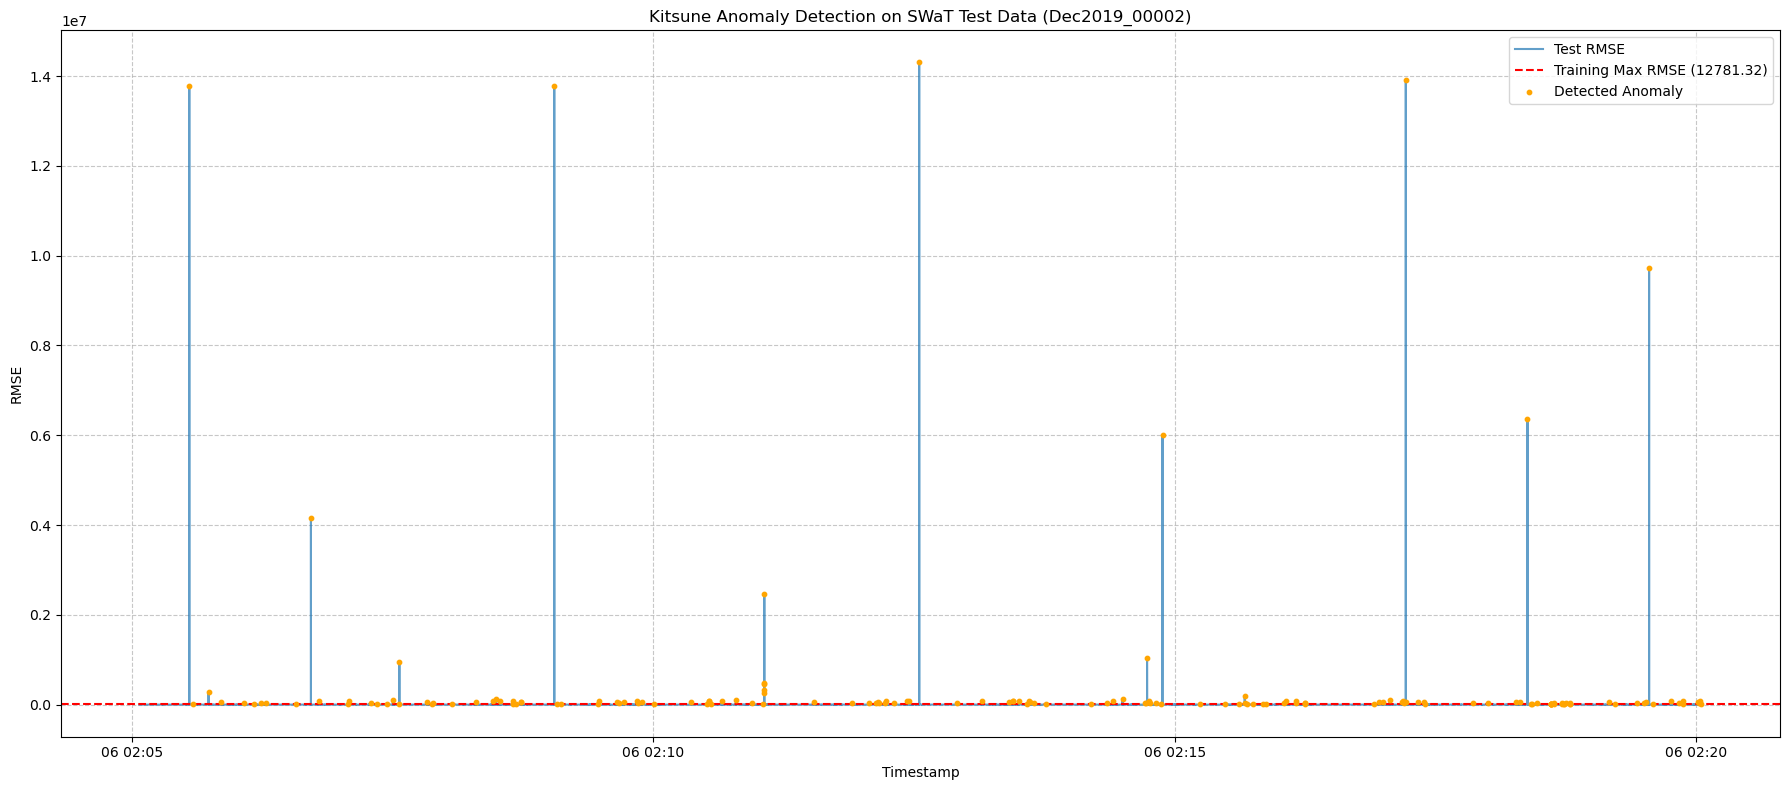


--- Further Analysis (Example) ---

Sample False Positives (RMSE and Timestamp):
         packet_idx                      datetime          rmse
702901       702902 2019-12-06 02:05:33.008402109  1.377782e+07
753948       753949 2019-12-06 02:05:35.068959951  1.697603e+04
974629       974630 2019-12-06 02:05:44.104746103  2.837094e+05
1156675     1156676 2019-12-06 02:05:51.479346991  4.844993e+04
1468550     1468551 2019-12-06 02:06:04.249485970  3.166227e+04

Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


In [3]:
#7/3/25 1:55 PM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# --- Configuration ---
# Paths to your data files
PATH_TRAINING_THRESHOLD = r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\thresholds\thresholds_Dec2019_00000_20191206100500.pcap_20250616_054608.csv"
PATH_TEST_RMSE = r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00000_20191206100500.pcap_20250612_150518.csv"
PATH_ATTACKS = r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\df_attacks_with_network_attacks.csv"
PATH_LABELS = r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\Dec2019_with_labels.csv"

# --- 1. Load Data ---

print("Loading data...")

# Load training threshold
training_threshold_df = pd.read_csv(PATH_TRAINING_THRESHOLD)
max_rmse_training = training_threshold_df[training_threshold_df['ThresholdType'] == 'MaxRMSE']['Value'].iloc[0]
print(f"Max RMSE from training dataset: {max_rmse_training:.2f}")

# Load test RMSE data
# Given the RMSE file structure, it's already sorted by packet_idx/timestamp
test_rmse_df = pd.read_csv(PATH_TEST_RMSE)
# Convert Unix timestamp to datetime for easier comparison
test_rmse_df['datetime'] = pd.to_datetime(test_rmse_df['timestamp'], unit='s')
print(f"Loaded {len(test_rmse_df)} packets of test RMSE data.")

# Load attack definitions
attacks_df = pd.read_csv(PATH_ATTACKS)
# Convert 'DATETIME' column to datetime objects
attacks_df['DATETIME'] = pd.to_datetime(attacks_df['DATETIME'], format='%m/%d/%Y %H:%M:%S')
print(f"Loaded {len(attacks_df)} attack entries.")

# Load full labels (optional, mainly for understanding timestamps if needed for more complex analysis)
# This file seems to be more about sensor readings and overall attack labels per timestamp.
# We'll use the 'df_attacks_with_network_attacks.csv' for specific attack start/stop times.
# If you need to map packet_idx to actual label timestamps more precisely, this file might be useful.
# For now, we'll rely on the timestamps in rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv
# and the attack definitions in df_attacks_with_network_attacks.csv.
labels_df = pd.read_csv(PATH_LABELS)
labels_df['t_stamp'] = pd.to_datetime(labels_df['t_stamp'])
print(f"Loaded {len(labels_df)} overall label entries.")


# --- 2. Identify Anomalies in Test Data ---

print("\nIdentifying anomalies...")
# Apply the anomaly detection rule: Test RMSE > Max(Training RMSE)
test_rmse_df['is_anomaly'] = test_rmse_df['rmse'] > max_rmse_training

num_anomalies = test_rmse_df['is_anomaly'].sum()
print(f"Detected {num_anomalies} anomalous packets out of {len(test_rmse_df)} total packets.")
print(f"Percentage of anomalous packets: {(num_anomalies / len(test_rmse_df)) * 100:.2f}%")

# --- 3. Filter Attacks Relevant to the Test Dataset's Timeframe ---

# Determine the time range of the test RMSE data
test_start_time = test_rmse_df['datetime'].min()
test_end_time = test_rmse_df['datetime'].max()

print(f"\nTest data time range: {test_start_time} to {test_end_time}")

# Filter attacks that fall within or overlap with the test data timeframe
relevant_attacks = pd.DataFrame(columns=attacks_df.columns)
current_attack_start = None
current_attack_name = None

# Iterate through attacks_df to define attack periods
attack_periods = []
for index, row in attacks_df.iterrows():
    if 'start' in row['attack_number']:
        current_attack_start = row['DATETIME']
        current_attack_name = row['attack_number'].replace('-start', '')
    elif 'stop' in row['attack_number'] and current_attack_start is not None and \
         row['attack_number'].replace('-stop', '') == current_attack_name:
        attack_end_time = row['DATETIME']
        # Check for overlap with test data timeframe
        if not (attack_end_time < test_start_time or current_attack_start > test_end_time):
            attack_periods.append({
                'attack_number': current_attack_name,
                'start_time': current_attack_start,
                'end_time': attack_end_time
            })
        current_attack_start = None
        current_attack_name = None

relevant_attack_periods_df = pd.DataFrame(attack_periods)
print(f"Found {len(relevant_attack_periods_df)} relevant attack periods within the test data timeframe.")
if not relevant_attack_periods_df.empty:
    print("Relevant Attack Periods:")
    print(relevant_attack_periods_df)
else:
    print("No relevant attack periods found in the provided attack definitions for this test dataset's timeframe.")

# --- 4. Compare Detected Anomalies to Ground Truth Attacks ---

print("\nComparing detected anomalies to ground truth...")

# Initialize columns for ground truth
test_rmse_df['is_attack_ground_truth'] = False
test_rmse_df['attack_name'] = np.nan

# Label packets in the test RMSE dataframe that fall within relevant attack periods
for index, attack_row in relevant_attack_periods_df.iterrows():
    start_time = attack_row['start_time']
    end_time = attack_row['end_time']
    attack_name = attack_row['attack_number']

    mask = (test_rmse_df['datetime'] >= start_time) & (test_rmse_df['datetime'] <= end_time)
    test_rmse_df.loc[mask, 'is_attack_ground_truth'] = True
    test_rmse_df.loc[mask, 'attack_name'] = attack_name

# Calculate True Positives, False Positives, False Negatives
true_positives_df = test_rmse_df[(test_rmse_df['is_anomaly'] == True) & (test_rmse_df['is_attack_ground_truth'] == True)]
false_positives_df = test_rmse_df[(test_rmse_df['is_anomaly'] == True) & (test_rmse_df['is_attack_ground_truth'] == False)]
false_negatives_df = test_rmse_df[(test_rmse_df['is_anomaly'] == False) & (test_rmse_df['is_attack_ground_truth'] == True)]
true_negatives_df = test_rmse_df[(test_rmse_df['is_anomaly'] == False) & (test_rmse_df['is_attack_ground_truth'] == False)]

print(f"\n--- Anomaly Detection Performance ---")
print(f"Total packets in test data: {len(test_rmse_df)}")
print(f"Actual attack packets (ground truth): {test_rmse_df['is_attack_ground_truth'].sum()}")
print(f"Detected anomalous packets: {test_rmse_df['is_anomaly'].sum()}")
print(f"True Positives (Anomalous & Actual Attack): {len(true_positives_df)}")
print(f"False Positives (Anomalous & NOT Actual Attack): {len(false_positives_df)}")
print(f"False Negatives (NOT Anomalous & Actual Attack): {len(false_negatives_df)}")
print(f"True Negatives (NOT Anomalous & NOT Actual Attack): {len(true_negatives_df)}")

# --- Optional: Visualization ---
print("\nGenerating visualization...")

plt.figure(figsize=(18, 8))
plt.plot(test_rmse_df['datetime'], test_rmse_df['rmse'], label='Test RMSE', alpha=0.7)
plt.axhline(y=max_rmse_training, color='r', linestyle='--', label=f'Training Max RMSE ({max_rmse_training:.2f})')

# Highlight detected anomalies
anomaly_timestamps = test_rmse_df[test_rmse_df['is_anomaly']]['datetime']
anomaly_rmses = test_rmse_df[test_rmse_df['is_anomaly']]['rmse']
plt.scatter(anomaly_timestamps, anomaly_rmses, color='orange', s=10, label='Detected Anomaly', zorder=5)

# Highlight actual attack periods
for index, attack_row in relevant_attack_periods_df.iterrows():
    plt.axvspan(attack_row['start_time'], attack_row['end_time'], color='gray', alpha=0.3, label=f'Actual Attack: {attack_row["attack_number"]}' if index == 0 else "")

plt.title('Kitsune Anomaly Detection on SWaT Test Data (Dec2019_00002)')
plt.xlabel('Timestamp')
plt.ylabel('RMSE')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# --- Optional: Further Analysis ---
print("\n--- Further Analysis (Example) ---")

# Print some False Positives for inspection
if not false_positives_df.empty:
    print("\nSample False Positives (RMSE and Timestamp):")
    print(false_positives_df[['packet_idx', 'datetime', 'rmse']].head())

# Print some False Negatives for inspection
if not false_negatives_df.empty:
    print("\nSample False Negatives (RMSE and Timestamp):")
    print(false_negatives_df[['packet_idx', 'datetime', 'rmse', 'attack_name']].head())

# Calculate Precision, Recall, F1-Score
# Avoid division by zero
precision = len(true_positives_df) / (len(true_positives_df) + len(false_positives_df)) if (len(true_positives_df) + len(false_positives_df)) > 0 else 0
recall = len(true_positives_df) / (len(true_positives_df) + len(false_negatives_df)) if (len(true_positives_df) + len(false_negatives_df)) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

Loading data...
Max RMSE from training dataset: 12781.32
Loaded 22343612 packets of test RMSE data.
Loaded 18 attack entries.
Loaded 13201 overall label entries.

Identifying anomalies...
Detected 190 anomalous packets out of 22343612 total packets.
Percentage of anomalous packets: 0.00%

Test data UTC time range: 2019-12-06 02:30:00.263128996+00:00 to 2019-12-06 02:45:00.028381109+00:00
Found 2 relevant attack periods within the test data timeframe (UTC).
Relevant Attack Periods (UTC):
  attack_number                start_time                  end_time
0             1 2019-12-06 02:30:00+00:00 2019-12-06 02:34:59+00:00
1             2 2019-12-06 02:45:00+00:00 2019-12-06 02:49:59+00:00

Comparing detected anomalies to ground truth...


C:\Users\jckso\AppData\Local\Temp\ipykernel_8428\932804370.py:117: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_rmse_df.loc[mask, 'attack_name'] = attack_name



--- Anomaly Detection Performance ---
Total packets in test data: 22343612
Actual attack packets (ground truth): 7599934
Detected anomalous packets: 190
True Positives (Anomalous & Actual Attack): 88
False Positives (Anomalous & NOT Actual Attack): 102
False Negatives (NOT Anomalous & Actual Attack): 7599846
True Negatives (NOT Anomalous & NOT Actual Attack): 14743576

Generating visualization...


C:\Users\jckso\AppData\Local\Temp\ipykernel_8428\932804370.py:157: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\jckso\anaconda3\envs\kitsune_v3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


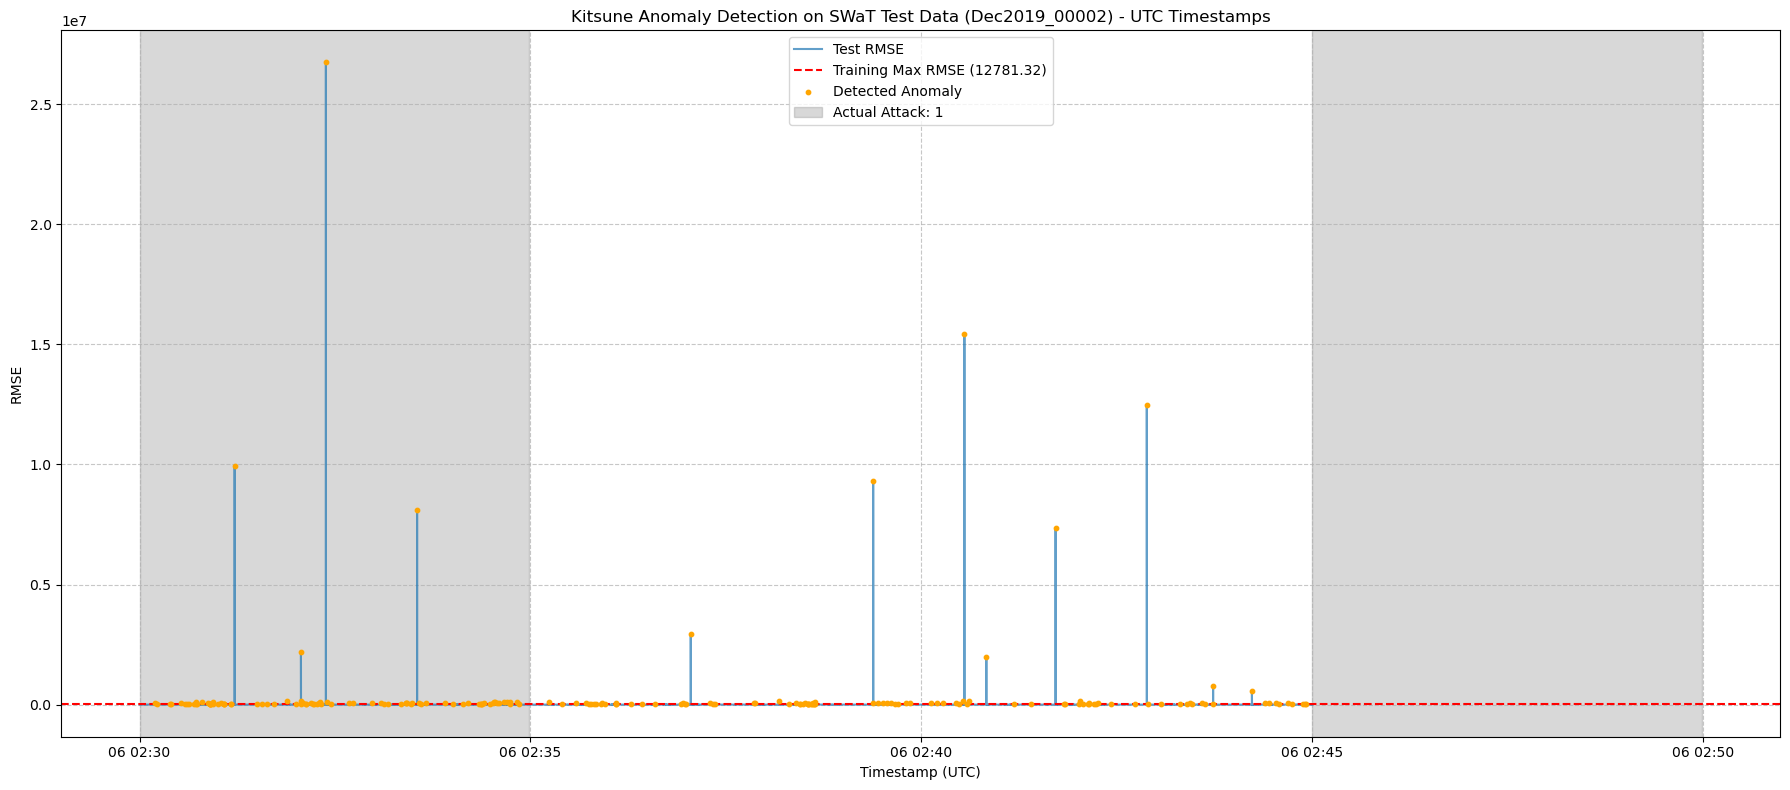


--- Further Analysis (Example) ---

Sample False Positives (RMSE and Timestamp):
         packet_idx                        datetime_utc           rmse
7990843     7990844 2019-12-06 02:35:14.295330048+00:00  113651.994497
8249133     8249134 2019-12-06 02:35:24.391446114+00:00   41505.494655
8505893     8505894 2019-12-06 02:35:34.592880011+00:00   81040.635657
8700329     8700330 2019-12-06 02:35:42.440356016+00:00   61175.548116
8763476     8763477 2019-12-06 02:35:45.048228979+00:00   29324.736882

Sample False Negatives (RMSE and Timestamp):
   packet_idx                        datetime_utc  rmse attack_name
0           1 2019-12-06 02:30:00.263128996+00:00   0.0           1
1           2 2019-12-06 02:30:00.263284921+00:00   0.0           1
2           3 2019-12-06 02:30:00.263286114+00:00   0.0           1
3           4 2019-12-06 02:30:00.263286114+00:00   0.0           1
4           5 2019-12-06 02:30:00.263287067+00:00   0.0           1

Precision: 0.4632
Recall: 0.0000
F1-S

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz # Import pytz for timezone handling

# --- Configuration ---
# Paths to your data files
PATH_TRAINING_THRESHOLD = r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\thresholds\thresholds_Dec2019_00000_20191206100500.pcap_20250616_054608.csv"
PATH_TEST_RMSE = r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\Results\rmse\rmse_Dec2019_00002_20191206103000.pcap_time=20250629_220912.csv"
PATH_ATTACKS = r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\df_attacks_with_network_attacks.csv"
PATH_LABELS = r"C:\Users\jckso\.vscode\Kitsune-py-master - Claude2\A6-2015-12\Dec2019_with_labels.csv"

# Define the local timezone for the attack and label files (SWaT is in Singapore, UTC+8)
SWAT_LOCAL_TZ = pytz.timezone('Asia/Singapore') # Or 'Etc/GMT-8' for a fixed offset

# --- 1. Load Data ---

print("Loading data...")

# Load training threshold
training_threshold_df = pd.read_csv(PATH_TRAINING_THRESHOLD)
max_rmse_training = training_threshold_df[training_threshold_df['ThresholdType'] == 'MaxRMSE']['Value'].iloc[0]
print(f"Max RMSE from training dataset: {max_rmse_training:.2f}")

# Load test RMSE data
# 'timestamp' column is a Unix timestamp, which is inherently UTC.
test_rmse_df = pd.read_csv(PATH_TEST_RMSE)
test_rmse_df['datetime_utc'] = pd.to_datetime(test_rmse_df['timestamp'], unit='s', utc=True)
print(f"Loaded {len(test_rmse_df)} packets of test RMSE data.")

# Load attack definitions
attacks_df = pd.read_csv(PATH_ATTACKS)
# Convert 'DATETIME' column to datetime objects
attacks_df['DATETIME'] = pd.to_datetime(attacks_df['DATETIME'], format='%m/%d/%Y %H:%M:%S')
# Localize to SWaT local timezone and then convert to UTC
attacks_df['DATETIME_UTC'] = attacks_df['DATETIME'].dt.tz_localize(SWAT_LOCAL_TZ, ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
print(f"Loaded {len(attacks_df)} attack entries.")

# Load full labels (optional, mainly for understanding timestamps if needed for more complex analysis)
labels_df = pd.read_csv(PATH_LABELS)
labels_df['t_stamp'] = pd.to_datetime(labels_df['t_stamp'])
# Localize to SWaT local timezone and then convert to UTC
labels_df['t_stamp_utc'] = labels_df['t_stamp'].dt.tz_localize(SWAT_LOCAL_TZ, ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
print(f"Loaded {len(labels_df)} overall label entries.")


# --- 2. Identify Anomalies in Test Data ---

print("\nIdentifying anomalies...")
# Apply the anomaly detection rule: Test RMSE > Max(Training RMSE)
test_rmse_df['is_anomaly'] = test_rmse_df['rmse'] > max_rmse_training

num_anomalies = test_rmse_df['is_anomaly'].sum()
print(f"Detected {num_anomalies} anomalous packets out of {len(test_rmse_df)} total packets.")
print(f"Percentage of anomalous packets: {(num_anomalies / len(test_rmse_df)) * 100:.2f}%")

# --- 3. Filter Attacks Relevant to the Test Dataset's Timeframe ---

# Determine the time range of the test RMSE data (now using the UTC datetime column)
test_start_time_utc = test_rmse_df['datetime_utc'].min()
test_end_time_utc = test_rmse_df['datetime_utc'].max()

print(f"\nTest data UTC time range: {test_start_time_utc} to {test_end_time_utc}")

# Filter attacks that fall within or overlap with the test data timeframe
relevant_attacks = pd.DataFrame(columns=['attack_number', 'start_time', 'end_time'])
current_attack_start_utc = None
current_attack_name = None

# Iterate through attacks_df to define attack periods using UTC timestamps
attack_periods = []
for index, row in attacks_df.iterrows():
    if 'start' in row['attack_number']:
        current_attack_start_utc = row['DATETIME_UTC']
        current_attack_name = row['attack_number'].replace('-start', '')
    elif 'stop' in row['attack_number'] and current_attack_start_utc is not None and \
         row['attack_number'].replace('-stop', '') == current_attack_name:
        attack_end_time_utc = row['DATETIME_UTC']
        
        # Check for overlap with test data timeframe (using UTC times)
        # An attack period overlaps if its end time is not before the test start, AND its start time is not after the test end.
        if not (attack_end_time_utc < test_start_time_utc or current_attack_start_utc > test_end_time_utc):
            attack_periods.append({
                'attack_number': current_attack_name,
                'start_time': current_attack_start_utc,
                'end_time': attack_end_time_utc
            })
        current_attack_start_utc = None
        current_attack_name = None

relevant_attack_periods_df = pd.DataFrame(attack_periods)
print(f"Found {len(relevant_attack_periods_df)} relevant attack periods within the test data timeframe (UTC).")
if not relevant_attack_periods_df.empty:
    print("Relevant Attack Periods (UTC):")
    print(relevant_attack_periods_df)
else:
    print("No relevant attack periods found in the provided attack definitions for this test dataset's timeframe, even after timezone conversion.")

# --- 4. Compare Detected Anomalies to Ground Truth Attacks ---

print("\nComparing detected anomalies to ground truth...")

# Initialize columns for ground truth
test_rmse_df['is_attack_ground_truth'] = False
test_rmse_df['attack_name'] = np.nan

# Label packets in the test RMSE dataframe that fall within relevant attack periods
for index, attack_row in relevant_attack_periods_df.iterrows():
    start_time = attack_row['start_time']
    end_time = attack_row['end_time']
    attack_name = attack_row['attack_number']

    # Use the UTC datetime column for comparison
    mask = (test_rmse_df['datetime_utc'] >= start_time) & (test_rmse_df['datetime_utc'] <= end_time)
    test_rmse_df.loc[mask, 'is_attack_ground_truth'] = True
    test_rmse_df.loc[mask, 'attack_name'] = attack_name

# Calculate True Positives, False Positives, False Negatives
true_positives_df = test_rmse_df[(test_rmse_df['is_anomaly'] == True) & (test_rmse_df['is_attack_ground_truth'] == True)]
false_positives_df = test_rmse_df[(test_rmse_df['is_anomaly'] == True) & (test_rmse_df['is_attack_ground_truth'] == False)]
false_negatives_df = test_rmse_df[(test_rmse_df['is_anomaly'] == False) & (test_rmse_df['is_attack_ground_truth'] == True)]
true_negatives_df = test_rmse_df[(test_rmse_df['is_anomaly'] == False) & (test_rmse_df['is_attack_ground_truth'] == False)]

print(f"\n--- Anomaly Detection Performance ---")
print(f"Total packets in test data: {len(test_rmse_df)}")
print(f"Actual attack packets (ground truth): {test_rmse_df['is_attack_ground_truth'].sum()}")
print(f"Detected anomalous packets: {test_rmse_df['is_anomaly'].sum()}")
print(f"True Positives (Anomalous & Actual Attack): {len(true_positives_df)}")
print(f"False Positives (Anomalous & NOT Actual Attack): {len(false_positives_df)}")
print(f"False Negatives (NOT Anomalous & Actual Attack): {len(false_negatives_df)}")
print(f"True Negatives (NOT Anomalous & NOT Actual Attack): {len(true_negatives_df)}")

# --- Optional: Visualization ---
print("\nGenerating visualization...")

plt.figure(figsize=(18, 8))
plt.plot(test_rmse_df['datetime_utc'], test_rmse_df['rmse'], label='Test RMSE', alpha=0.7)
plt.axhline(y=max_rmse_training, color='r', linestyle='--', label=f'Training Max RMSE ({max_rmse_training:.2f})')

# Highlight detected anomalies
anomaly_timestamps = test_rmse_df[test_rmse_df['is_anomaly']]['datetime_utc']
anomaly_rmses = test_rmse_df[test_rmse_df['is_anomaly']]['rmse']
plt.scatter(anomaly_timestamps, anomaly_rmses, color='orange', s=10, label='Detected Anomaly', zorder=5)

# Highlight actual attack periods
for index, attack_row in relevant_attack_periods_df.iterrows():
    # Ensure the label is only added once for the legend
    label = f'Actual Attack: {attack_row["attack_number"]}' if index == 0 else ""
    plt.axvspan(attack_row['start_time'], attack_row['end_time'], color='gray', alpha=0.3, label=label)

plt.title('Kitsune Anomaly Detection on SWaT Test Data (Dec2019_00002) - UTC Timestamps')
plt.xlabel('Timestamp (UTC)')
plt.ylabel('RMSE')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# --- Optional: Further Analysis ---
print("\n--- Further Analysis (Example) ---")

# Print some False Positives for inspection
if not false_positives_df.empty:
    print("\nSample False Positives (RMSE and Timestamp):")
    print(false_positives_df[['packet_idx', 'datetime_utc', 'rmse']].head())

# Print some False Negatives for inspection
if not false_negatives_df.empty:
    print("\nSample False Negatives (RMSE and Timestamp):")
    print(false_negatives_df[['packet_idx', 'datetime_utc', 'rmse', 'attack_name']].head())

# Calculate Precision, Recall, F1-Score
# Avoid division by zero
precision = len(true_positives_df) / (len(true_positives_df) + len(false_positives_df)) if (len(true_positives_df) + len(false_positives_df)) > 0 else 0
recall = len(true_positives_df) / (len(true_positives_df) + len(false_negatives_df)) if (len(true_positives_df) + len(false_negatives_df)) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
